### Install Packages that are not included in the course standard install tutorial

In [ ]:
# !pip install autograd
# !pip install scikit-plot
# !pip install seaborn
# !pip install keras-tuner
# !pip install tensorflow   

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__) # 2.20.0
print("Keras version:", tf.keras.__version__) # 3.13.0

TensorFlow version: 2.20.0
Keras version: 3.12.0


In [ ]:
# importing general libraries
import autograd.numpy as np 
from autograd import grad, elementwise_grad
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import string
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.mplot3d import Axes3D

# Sklear Library: datasets, tools for preprocessing and optimization, also the standard polynomial regression
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder, label_binarize, PolynomialFeatures, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, mean_squared_error
from sklearn import datasets
from sklearn.datasets import load_digits, load_breast_cancer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin  # not actuall anymore
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Keras wrapper for tensorflow, with keras tuner
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential      #This allows appending layers to existing models
from tensorflow.keras.layers import Dense           #This allows defining the characteristics of a particular layer
from tensorflow.keras import optimizers             #This allows using whichever optimiser we want (sgd,adam,RMSprop)
from tensorflow.keras import regularizers           #This allows using whichever regularizer we want (l1,l2,l1_l2)
from tensorflow.keras.utils import to_categorical   #This allows using categorical cross entropy as the cost function
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperModel, RandomSearch
import keras_tuner as kt

### Defining basis functions for FFNN and BackProp

In [62]:
### Hardcoded Values
traintestrat = 0.2    # train-test split ratio
figpath = 'C:\DATA_ANALYSIS_TEST\Proj2_Figs'

### Defining activation functions and their derivatives (compatible with batched input)

In [ ]:
def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_leaky(z, alpha=0.01):
    '''
    using input alpha, Leaky ReLu alows gradual recovery (leaking) of dead nodes 
    '''
    return np.where(z > 0, z, alpha * z)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)

def ReLU_leaky_der(z, alpha=0.01):
    return np.where(z > 0, 1, alpha)

def linear(z):
    return z

def linear_der(z):
    return np.ones_like(z)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    e_z = np.exp(z - np.max(z, axis=0))
    return e_z / np.sum(e_z, axis=1)[:, np.newaxis]

def softmax_stable(z):
    '''
    Modinfication using batch normalization
    avoiding overflow by subtracting the maximum of z per sample before exponentiating 
    '''
    z_stable = z - np.max(z, axis=1, keepdims=True)
    e_z = np.exp(z_stable)
    return e_z / np.sum(e_z, axis=1, keepdims=True)

def softmax_vec(z):
    '''
    Computes softmax values for each set of scores in the vector z
    used when computing activation function on one vector at a time
    '''
    e_z = np.exp(z - np.max(z))
    return e_z / np.sum(e_z)

def sigmoid_der(z):
    return sigmoid(z)*(1-sigmoid(z))

def mse(predict, target, weights=None, regularization=None, lambdaVal=0.0):
    """
    Mean Squared Error loss with optional L1/L2 regularization.
    """
    base_loss = np.mean((predict - target) ** 2)
    if regularization == 'L2' and weights is not None:
        reg_term = lambdaVal * np.sum(weights ** 2)
        return base_loss + reg_term
    elif regularization == 'L1' and weights is not None:
        reg_term = lambdaVal * np.sum(np.abs(weights))
        return base_loss + reg_term
    return base_loss

def mse_der(predict, target):
    '''
    Derivative of MSE with optional L1/L2 regularization.
    No regularization here (as its relevant for dCdw only), but there we make it an add-on in Backpropagation function)
    '''
    return 2 * (predict - target) / predict.shape[0]

def accuracy(predictions, targets):
    '''
    Compute classification accuracy (one-hot targets).
    '''
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(targets, axis=1)
    return np.mean(pred_classes == true_classes)

def cross_entropy(predict, target, weights=None, regularization=None, lambdaVal=0.0):
    '''
    Cross-entropy loss with optional L1/L2 regularization.
    '''
    epsilon = 1e-12
    predict = np.clip(predict, epsilon, 1. - epsilon)
    base_loss = -np.sum(target * np.log(predict)) / predict.shape[0]
    if regularization == 'L2' and weights is not None:
        base_loss += lambdaVal * np.sum(weights ** 2)
    elif regularization == 'L1' and weights is not None:
        base_loss += lambdaVal * np.sum(np.abs(weights))
    return base_loss

def cross_entropy_der(predict, target):
    '''
    Derivative for softmax + cross-entropy combination
    Regularization effect is inside the backpropagation function as a seperate add-on
    '''
    return (predict - target) / predict.shape[0]

### Functions used in FFNN and BackProp

In [ ]:
def BATCH_feed_forward(input, layers, activation_funcs):
    '''
    given batched input and architecture: (layers, activation functions) propagates the signal through the network
    returns the final output a_L
    '''
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = a@W+b                     # flipped a, W
        a = activation_func(z)
    return a

def BATCH_feed_forward_saver(input, layers, activation_funcs):
    '''
    modification: because backprop needs a save of all FFNN calculations (z)
    '''
    layer_inputs = []
    zs = []
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = a@W + b    #flipped a, W
        a = activation_func(z)
        zs.append(z)
    return layer_inputs, zs, a

def BATCH_cost(layers, input, activation_funcs, target, cost_type='entropy', regularization=None, lambdaVal=0.0):
    '''
    given batched inputs, architecture and target, aswell as cost function type (with regularization option)
    propagates the signal through the network using FF function
    returns the cost MSE/Cross Entropy
    '''
    predict = BATCH_feed_forward(input, layers, activation_funcs)
    if cost_type == 'entropy':
        return cross_entropy(predict, target, weights=np.concatenate([W.flatten() for W, _ in layers]), regularization=regularization,lambdaVal=lambdaVal)
    elif cost_type == 'mse':
        return mse(predict, target, weights=np.concatenate([W.flatten() for W, _ in layers]), regularization=regularization, lambdaVal=lambdaVal)
    
def BATCH_backpropagation(input, layers, activation_funcs, target, activation_ders, cost_der=cross_entropy_der, regularization=None, lambdaVal=0.0):
    """
    Batched backpropagation with L1/L2 regularization mod.
    inputs: input, architecture, target, cost function, regularization (y/n) 
    propagates the signal storing the z values
    computes wrt. trigger paramters (W, b)_l for each layer in reversed order using chain rule
    Note: if last function is softmax use a shortcut derivative for 
    Sotring intermediate trigger gradients for the chained update l->l-1
    Note: if regularization derivative, note the indexing (current stage update)
    returns the list of gradients for all layers corresponding to the architecture
    """
    layer_inputs, zs, predict = BATCH_feed_forward_saver(input, layers, activation_funcs)
    layer_grads = [() for layer in layers]
    # We loop over the layers, from the last to the first
    dC_dz_next = None  # Store gradient from next (up-lvl) layer
    for i in reversed(range(len(layers))):
        W, b = layers[i]  #current layer
        layer_input, z, activation_der_func = layer_inputs[i], zs[i], activation_ders[i]
        activation_der_values = activation_der_func(z)
        if i == len(layers) - 1:
            # For last layer: dC_dz = cost_der*activation_der_values
            if cost_der == cross_entropy_der:
                dC_dz = cost_der(predict, target)  #this is a combo for cross entropy and softmax!!!
            elif cost_der == mse_der:
                dC_da = cost_der(predict, target)
                dC_dz = dC_da*activation_der_values
        else:
            # For hidden layers: (inheritance) @ (up-lvel W) * (new activation derivative)
            # dC_dz = dC_dz_next@W_next.T  * activation_der_values
            W_next, b_next = layers[i + 1] #downstream layer
            dC_da = dC_dz_next@W_next.T
            dC_dz = dC_da * activation_der_values
        # Compute gradients for this layer
        dC_dW = layer_input.T@dC_dz # for batched input
        dC_db = np.sum(dC_dz, axis=0) # changed to sum over batches
        # Regularization Add-on (using current layer W!)
        if regularization == 'L2':
            dC_dW += 2*lambdaVal*W
        elif regularization == 'L1':
            dC_dW += lambdaVal*np.sign(W)
        # Store this lvl 
        dC_dz_next = dC_dz
        layer_grads[i] = (dC_dW, dC_db)
    return layer_grads

### Optimization (GD) class **YAGDI_NN**

In [ ]:
class yagdi_NN:
    '''
    Yet Another Gradient Descent Index for Neural Networks
    ------------------------------------------------------
    ProblemType: classification/regression (defined cost type, mse or cross entropy)
    optimizer: vanillagd/momentum/adagrad/rmsprop/adam
    batch_type: batch/stochastic/minibatch 
    regularization: None/L2/L1
    '''
    def __init__(self, ProblemType='classification', learning_rate=0.01, optimizer='vanillagd', regularization=None, lambdaVal=0.0, max_iter=1000, max_epoch=100, tol=1e-6, momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8, batch_type='batch', batch_size=32):
        self.problem_type = ProblemType
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.max_epoch = max_epoch
        self.optimizer = optimizer
        self.regularization = regularization
        self.lambdaVal = lambdaVal
        self.momentum = momentum
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.batch_type = batch_type
        self.batch_size = batch_size

        # Initialize state (different momentum types)
        self.velocity_W = None
        self.velocity_b = None
        self.G_W = None
        self.G_b = None
        self.G2_W = None
        self.G2_b = None
        self.G3_W = None
        self.G3_b = None
        self.G4_W = None
        self.G4_b = None
        self.t = 0
    
    def initialize_for_layers(self, layers):
        '''
        Initialize optimizer state for the given layers fit momentum to the architecture 
        '''
        self.velocity_W = [np.zeros_like(W) for W, b in layers]
        self.velocity_b = [np.zeros_like(b) for W, b in layers]
        self.G_W = [np.zeros_like(W) for W, b in layers]
        self.G_b = [np.zeros_like(b) for W, b in layers]
        self.G2_W = [np.zeros_like(W) for W, b in layers]
        self.G2_b = [np.zeros_like(b) for W, b in layers]
        self.G3_W = [np.zeros_like(W) for W, b in layers]
        self.G3_b = [np.zeros_like(b) for W, b in layers]
        self.G4_W = [np.zeros_like(W) for W, b in layers]
        self.G4_b = [np.zeros_like(b) for W, b in layers]
        self.t = 0
    
    def _get_batch(self, X, y):
        '''
        Select 1 random batch based on batch_type
        Note: modification from previous YAGDI, 1 selection per epoch
        '''
        n_samples = X.shape[0]

        if self.batch_type == 'batch':
            return X, y  # Full dataset
        elif self.batch_type == 'stochastic':
            # Single random sample (mini-batch size=1)
            idx = np.random.randint(n_samples)
            return X[idx:idx+1], y[idx:idx+1]
        elif self.batch_type == 'minibatch':
            # ONE random mini-batch 
            batch_size = min(self.batch_size, n_samples)
            indices = np.random.choice(n_samples, batch_size, replace=False)
            return X[indices], y[indices]
    
    def fit(self, X, y, layers, activation_funcs, activation_ders):
        '''
        Main training method - uses backpropagation internally
        compared to proj1, only 1 batch is evaluated er epoch 
        '''
        # Initialize optimizer variables ONCE
        self.initialize_for_layers(layers)
        
        total_iterations = 0
        converged = False
        
        # EPOCH LOOP 
        for epoch in range(self.max_epoch):

            # exit statement (iterations)
            if total_iterations >= self.max_iter:
                break
            if converged:
                break
            
            # Get ONE random batch per epoch
            X_batch, y_batch = self._get_batch(X, y)
            
            # Compute gradients using backpropagation
            if self.problem_type=='classification':
                gradients = BATCH_backpropagation(X_batch, layers, activation_funcs, y_batch, activation_ders, cost_der=cross_entropy_der, regularization=self.regularization, lambdaVal=self.lambdaVal)
            elif self.problem_type=='regression':
                gradients = BATCH_backpropagation(X_batch, layers, activation_funcs, y_batch, activation_ders, cost_der=mse_der, regularization=self.regularization, lambdaVal=self.lambdaVal)
            else:
                raise ValueError(f"Unknown problem type: {self.type}")
            
            # Apply optimizer update
            layers = self._apply_optimizer_update(layers, gradients)
            total_iterations += 1

            grad_norm = self._compute_gradient_norm(gradients)
            if grad_norm < self.tol:
                converged = True
                break

        return layers

    def _compute_gradient_norm(self, gradients):
        '''
        Compute norm of all gradients for convergence check
        '''
        total_norm = 0
        for dW, db in gradients:
            total_norm += np.sum(dW**2) + np.sum(db**2)
        return np.sqrt(total_norm)
    
    def _apply_optimizer_update(self, layers, gradients):
        '''
        Layer adaptive-GD updates
        Note: with regularization inside gradients!
        '''
        updated_layers = []
        for layer_idx, ((W, b), (dW, db)) in enumerate(zip(layers, gradients)):

            if self.optimizer == 'vanillagd':
                W_new = W - self.learning_rate * dW
                b_new = b - self.learning_rate * db
                
            elif self.optimizer == 'momentum':
                self.velocity_W[layer_idx] = self.momentum * self.velocity_W[layer_idx] - self.learning_rate * dW
                self.velocity_b[layer_idx] = self.momentum * self.velocity_b[layer_idx] - self.learning_rate * db
                
                W_new = W + self.velocity_W[layer_idx]
                b_new = b + self.velocity_b[layer_idx]
                
            elif self.optimizer == 'adagrad':
                self.G_W[layer_idx] += dW**2
                self.G_b[layer_idx] += db**2
                
                lr_W = self.learning_rate / (np.sqrt(self.G_W[layer_idx]) + self.epsilon)
                lr_b = self.learning_rate / (np.sqrt(self.G_b[layer_idx]) + self.epsilon)
                
                W_new = W - lr_W * dW
                b_new = b - lr_b * db
                
            elif self.optimizer == 'rmsprop':
                self.G2_W[layer_idx] = self.beta1 * self.G2_W[layer_idx] + (1 - self.beta1) * dW**2
                self.G2_b[layer_idx] = self.beta1 * self.G2_b[layer_idx] + (1 - self.beta1) * db**2
                
                lr_W = self.learning_rate / (np.sqrt(self.G2_W[layer_idx]) + self.epsilon)
                lr_b = self.learning_rate / (np.sqrt(self.G2_b[layer_idx]) + self.epsilon)
                
                W_new = W - lr_W * dW
                b_new = b - lr_b * db
                
            elif self.optimizer == 'adam':
                self.t += 1
                
                # First moment
                self.G3_W[layer_idx] = self.beta1 * self.G3_W[layer_idx] + (1 - self.beta1) * dW
                self.G3_b[layer_idx] = self.beta1 * self.G3_b[layer_idx] + (1 - self.beta1) * db
                
                # Second moment
                self.G4_W[layer_idx] = self.beta2 * self.G4_W[layer_idx] + (1 - self.beta2) * dW**2
                self.G4_b[layer_idx] = self.beta2 * self.G4_b[layer_idx] + (1 - self.beta2) * db**2
                
                # Bias correction
                m_W_hat = self.G3_W[layer_idx] / (1 - self.beta1**self.t)
                m_b_hat = self.G3_b[layer_idx] / (1 - self.beta1**self.t)
                v_W_hat = self.G4_W[layer_idx] / (1 - self.beta2**self.t)
                v_b_hat = self.G4_b[layer_idx] / (1 - self.beta2**self.t)
                
                # Update
                W_new = W - self.learning_rate * m_W_hat / (np.sqrt(v_W_hat) + self.epsilon)
                b_new = b - self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)
            
            else:
                # Fallback to vanilla GD
                W_new = W - self.learning_rate * dW
                b_new = b - self.learning_rate * db
            
            updated_layers.append((W_new, b_new))
        
        return updated_layers 

### Simple Neural Network (without covolution or reccurent stages): **YANNI** 

In [ ]:
class YANNI:
    def __init__(self, ProblemType='classification', network_architecture=None, activation_funcs=None, optimizer='adam', batch_type='minibatch', regularization=None, learning_rate=0.01, batch_size=32, lambdaVal=0.0, max_iter=1000, max_epoch=100, tol=1e-6, momentum=0.9, beta1=0.9, beta2=0.999, epsilon=1e-8):
        '''
        Yet Another Neural Network Index
        - Network architecture setup
        - Forward propagation  
        - Training in yagdi_NN optimizer GD (handles backpropagation internally)

        Paramters: 
            problem type: regression or classification, forwards the info to yagdi_NN (where it will mean mse or cross entropy cost)
            network_architecture: Layer sizes [input_size, hidden1_size, hidden2_size, ..., output_size]
            activation_funcs: list of function names (derivatives are mapped inside, just make sure the function are pre-defined)
            learning_rate, batch_size, max_iter, max_epoch, tol (defaults) for yagdi_NN
            provide: optimizer('adam', 'vanillagd', 'rmsprop', 'momentum'), batch_type('minibatch', 'stochastic', 'batch') and regularization('L2', 'L1')
            regulariation option unavailable
        '''
        self.ProblemType = ProblemType.lower()
        self.network_architecture = network_architecture
        self.activation_funcs = activation_funcs
        self.activation_ders = self._get_activation_derivatives(activation_funcs)
        
        # Initialize layers
        self.layers = self._create_layers(network_architecture)
        
        # Initialize optimizer (yagdi_NN handles backpropagation internally)
        self.optimizer = yagdi_NN(
            ProblemType=self.ProblemType,
            regularization=regularization,
            learning_rate=learning_rate,
            lambdaVal=lambdaVal,
            optimizer=optimizer,
            max_iter=max_iter,
            max_epoch=max_epoch,
            tol=tol,
            batch_type=batch_type,
            batch_size=batch_size,
            momentum=momentum,
            beta1=beta1,
            beta2=beta2,
            epsilon=epsilon
        )

    def _to_onehot(self, y, n_classes=None):
        '''
        Convert class labels to one-hot encoding
        '''
        if n_classes is None:
            n_classes = len(np.unique(y))
        return np.eye(n_classes)[y]
    
    def _create_layers(self, architecture):
        '''
        Build the network layers given architecture input
        returns list of init trigger prameters W, b (with random initialization)
        '''
        layers = []
        for i in range(len(architecture) - 1):
            input_size = architecture[i]
            output_size = architecture[i + 1]
            W = np.random.randn(input_size, output_size) * np.sqrt(2 / input_size)
            b = np.random.randn(output_size) * np.sqrt(2 / input_size)
            layers.append((W, b))
        return layers
    
    def _get_activation_derivatives(self, activation_funcs):
        '''
        Map activation functions to their derivatives
        '''
        derivative_map = {
            sigmoid: sigmoid_der,
            ReLU: ReLU_der,
            ReLU_leaky: ReLU_leaky_der,
            softmax_stable: lambda x: 1,  
            softmax: lambda x: 1,  
            linear: linear_der
            # tanh: tanh_der
        }
        return [derivative_map[func] for func in activation_funcs]
    
    def forward_propagation(self, X):
        '''
        Forward the signal through the network
        Auxillary function during evaluatation
        '''
        return BATCH_feed_forward(X, self.layers, self.activation_funcs)
    
    def compute_cost(self, X, y):
        '''
        Compute cost on given data
        Auxillary function during evaluation
        Cost = mse (regression), cross entropy (classification)
        '''
        if self.ProblemType == 'regression':
            return BATCH_cost(layers=self.layers, input=X, activation_funcs=self.activation_funcs, target=y, cost_type='mse', regularization=self.optimizer.regularization, lambdaVal=self.optimizer.lambdaVal)
        elif self.ProblemType == 'classification':
            return BATCH_cost(layers=self.layers, input=X, activation_funcs=self.activation_funcs, target=y, cost_type='entropy', regularization=self.optimizer.regularization, lambdaVal=self.optimizer.lambdaVal)
    
    def compute_accuracy(self, X, y):
        '''
        Compute accuracy on given data
        finds predictions using FF, and compares with labeled targets using the eye (identiy) as Indicator function
        compatible with classification type 
        '''
        predictions = self.forward_propagation(X)
        predicted_classes = np.argmax(predictions, axis=1)

        # Handle both one-hot and class labels
        if y.ndim == 2 and y.shape[1] > 1:  # One-hot encoded
            true_classes = np.argmax(y, axis=1)
        else:  # Class labels (flatten to 1D array)
            true_classes = y.reshape(-1)
            
        return np.mean(predicted_classes == true_classes)
    
    def train(self, X_train, y_train, X_val=None, y_val=None, verbose=True):
        '''
        Complete training using yagdi_NN optimizer
        yagdi_NN handles backpropagation internally
        '''
        if self.ProblemType == 'classification':
            # Convert to one-hot for training (works for both formats)
            if y_train.ndim == 1:  # Class labels
                y_train_onehot = self._to_onehot(y_train, n_classes=self.network_architecture[-1])
            else:  # Already one-hot
                y_train_onehot = y_train
        elif self.ProblemType == 'regression':
            y_train_onehot = y_train

        # Train using yagdi_NN (which calls BATCH_backpropagation internally)
        self.layers = self.optimizer.fit(
            X=X_train,
            y=y_train_onehot,
            layers=self.layers,
            activation_funcs=self.activation_funcs,
            activation_ders=self.activation_ders
        )
    
    def predict(self, X):
        '''
        Make predictions on new data
        '''
        return self.forward_propagation(X)
    
    def predict_classes(self, X):
        '''
        Return class predictions the most likely of Tre/False or multiple if multiclass
        '''
        predictions = self.predict(X)
        return np.argmax(predictions, axis=1)
    
    def predict_proba(self, X):
        '''
        Make probability predictions on new data 
        '''
        return self.forward_propagation(X)
    
    def _ensure_class_labels(self, y):
        '''
        Convert any format to class labels - UNIVERSAL
        '''
        if y.ndim == 2 and y.shape[1] > 1:  # One-hot
            return np.argmax(y, axis=1)
        else:  # Class labels
            return y.reshape(-1)
    
    def plot_confusion_matrix(self, X, y_true, normalize='true'):
        '''
        Plot confusion matrix - UNIVERSAL
        '''
        y_pred = self.predict_classes(X)
        y_true_classes = self._ensure_class_labels(y_true)
        
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true_classes, y_pred,
            normalize=normalize,
            cmap=plt.cm.Blues,
            values_format='.2f'
        )
        plt.title('Normalized Confusion Matrix')
        # plt.savefig(rf"{figpath}\{self.ProblemType}_ConfusionMatrix.png") #unbcode if you want to save into specific location
        plt.show()
    
    def plot_roc_curves(self, X, y_true):
        '''
        Plot ROC curves - UNIVERSAL
        '''
        y_score = self.predict_proba(X)
        y_true_classes = self._ensure_class_labels(y_true)
        classes = np.unique(y_true_classes)
        n_classes = len(classes)
        
        # Binarize the labels for multiclass
        y_true_bin = label_binarize(y_true_classes, classes=classes)
        
        fig, ax = plt.subplots(figsize=(8, 6))

        if n_classes == 2:
            # For binary: y_true_bin has shape (n_samples,1), add the negative class
            y_true_bin = np.hstack([1 - y_true_bin, y_true_bin])

        for class_idx in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, class_idx], y_score[:, class_idx])
            roc_auc = auc(fpr, tpr)
            display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, name=f'Class {classes[class_idx]}')
            display.plot(ax=ax)
        
        ax.plot([0, 1], [0, 1], 'k--', label='Random classifier')
        ax.legend()
        plt.title('ROC Curves')
        plt.grid(True)
        # plt.savefig(rf"{figpath}\{self.ProblemType}_ROCcurve.png")
        plt.show()
    
    def plot_cumulative_gain(self, X, y_true):
        '''
        Plot cumulative gain curves - UNIVERSAL
        '''
        y_score = self.predict_proba(X)
        y_true_classes = self._ensure_class_labels(y_true)
        classes = np.unique(y_true_classes)
        n_classes = len(classes)
        
        plt.figure(figsize=(8, 6))
        for class_idx in range(n_classes):
            y_true_binary = (y_true_classes == classes[class_idx]).astype(int)
            sort_idx = np.argsort(y_score[:, class_idx])[::-1]
            y_sorted = y_true_binary[sort_idx]
            
            # Handle case where there are no positive samples for this class
            if np.sum(y_sorted) > 0:
                cumulative_gains = np.cumsum(y_sorted) / np.sum(y_sorted)
            else:
                cumulative_gains = np.zeros_like(y_sorted, dtype=float)
                
            percentage_population = np.arange(1, len(y_sorted) + 1) / len(y_sorted)
            plt.plot(percentage_population, cumulative_gains, label=f'Class {classes[class_idx]}', lw=2)
        
        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', lw=2)
        plt.xlabel('Percentage of Sample')
        plt.ylabel('Gain')
        plt.title('Cumulative Gain Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        # plt.savefig(rf"{figpath}\{self.ProblemType}_CumGain.png")
        plt.show()
    
    def evaluate_model(self, X_test, y_test, Plot):
        '''
        Run all evaluations at once - UNIVERSAL
        '''
        print("=== Model Evaluation ===")
        
        if self.ProblemType == 'classification':
            # Accuracy
            test_acc = self.compute_accuracy(X_test, y_test)
            print(f"Test Accuracy: {test_acc:.4f}")
            
            # Plots
            if Plot:
                self.plot_confusion_matrix(X_test, y_test)
                self.plot_roc_curves(X_test, y_test)
                self.plot_cumulative_gain(X_test, y_test)
            return test_acc
        elif self.ProblemType == 'regression':
            # MSE cost
            test_cost = self.compute_cost(X_test, y_test)
            print(f"Test Cost (MSE): {test_cost:.4f}")
            
            # Plot prediction vs true data
            plt.figure(figsize=(6, 6))
            y_pred = self.predict(X_test)
            plt.scatter(y_test, y_pred, alpha=0.7)
            plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
            plt.xlabel("True Values")
            plt.ylabel("Predictions")
            plt.title("Regression Predictions vs True Values")
            plt.grid(True)
            plt.show()

# CLASSIFICATION

### Test Multiclass: **Iris Data**

### Feature Processing

(150, 4)
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


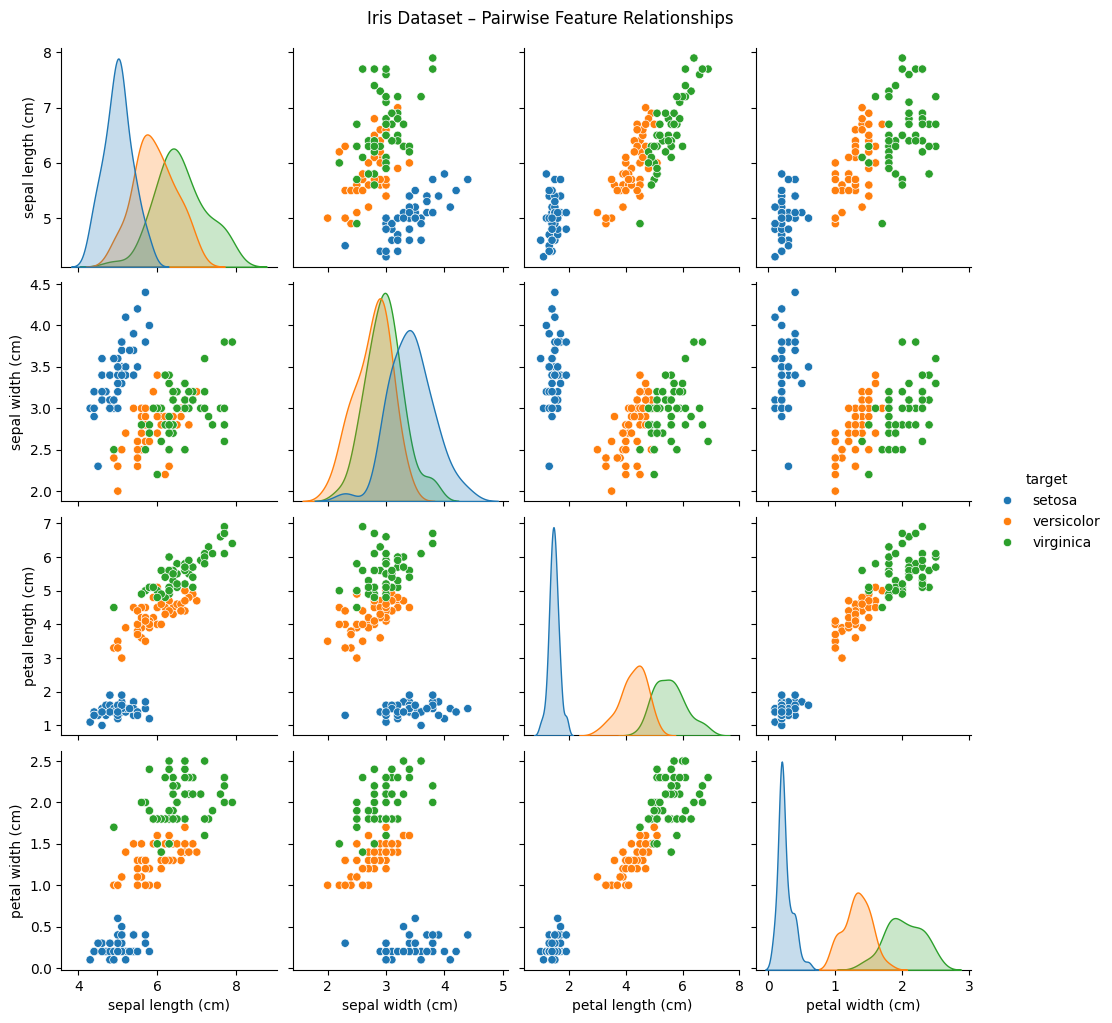

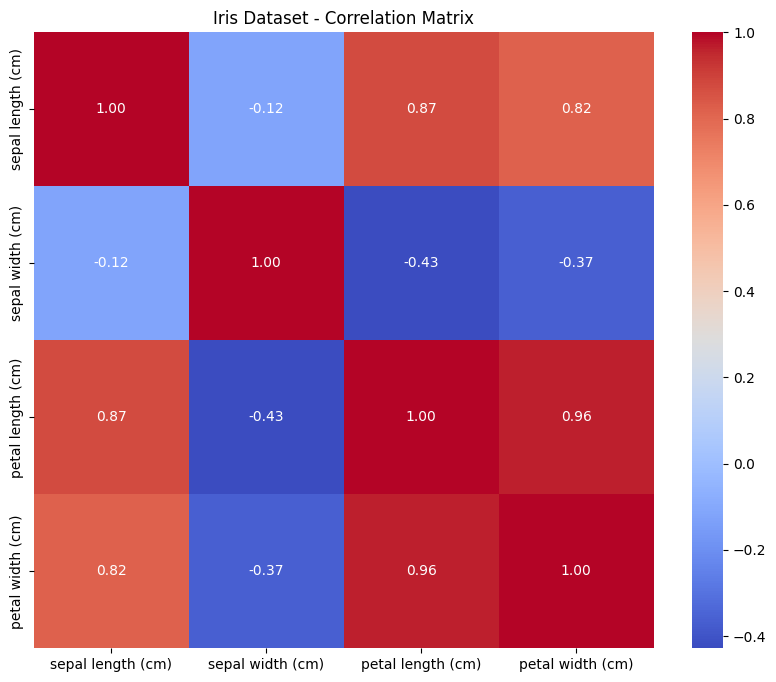

In [36]:
iris = datasets.load_iris()
X_iris = iris.data  # Features
y_iris = iris.target # Target labels

iris_feature_names = iris.feature_names

print(X_iris.shape)
print(iris_feature_names)

df_iris = pd.DataFrame(X_iris, columns=iris_feature_names)
df_iris['target'] = pd.Series(y_iris).map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

sns.pairplot(df_iris[iris_feature_names + ['target']], hue='target')
plt.suptitle("Iris Dataset – Pairwise Feature Relationships", y=1.02)
plt.show()

corr_matrix_iris = df_iris[iris_feature_names].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_iris, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Iris Dataset - Correlation Matrix")
plt.show()

### apply log-transform and stndardization to the features

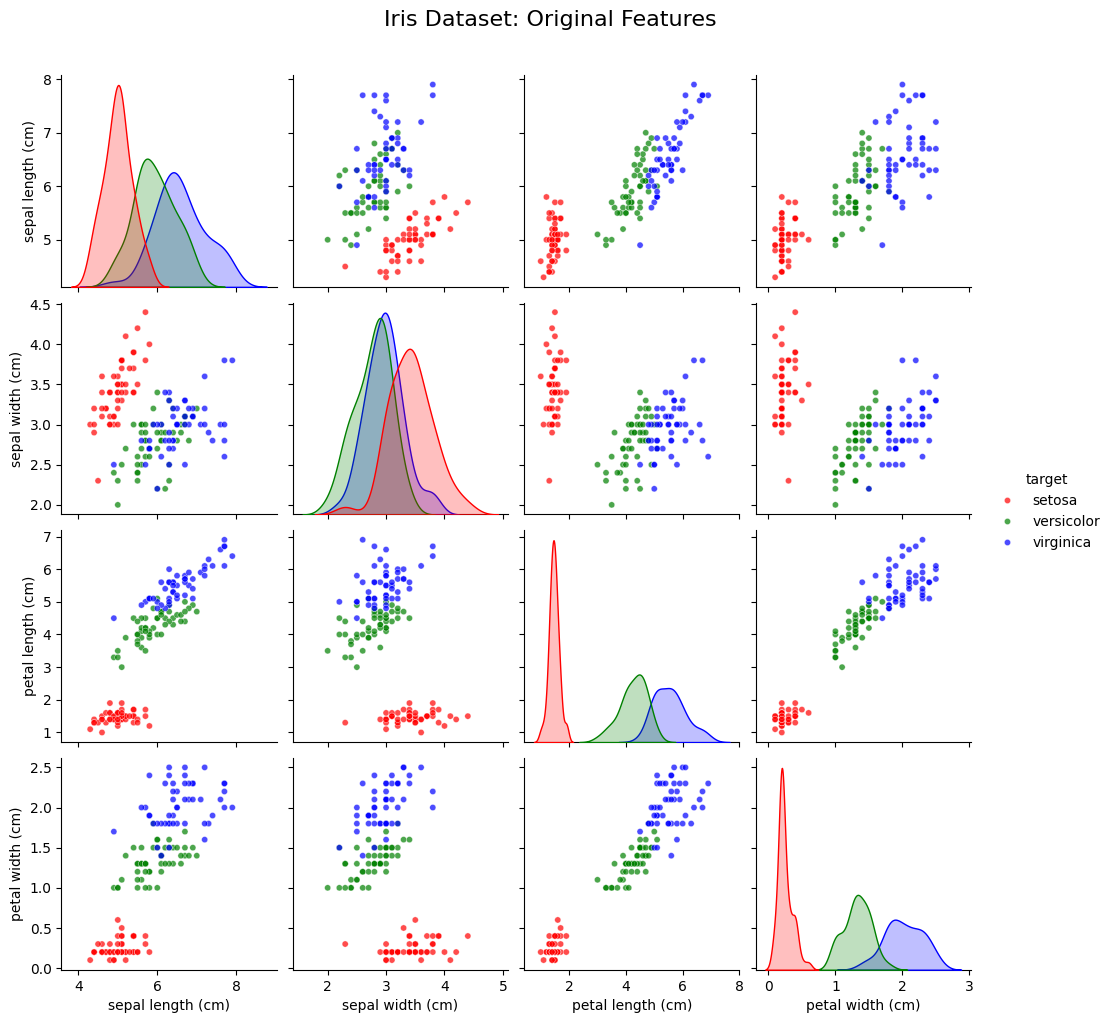

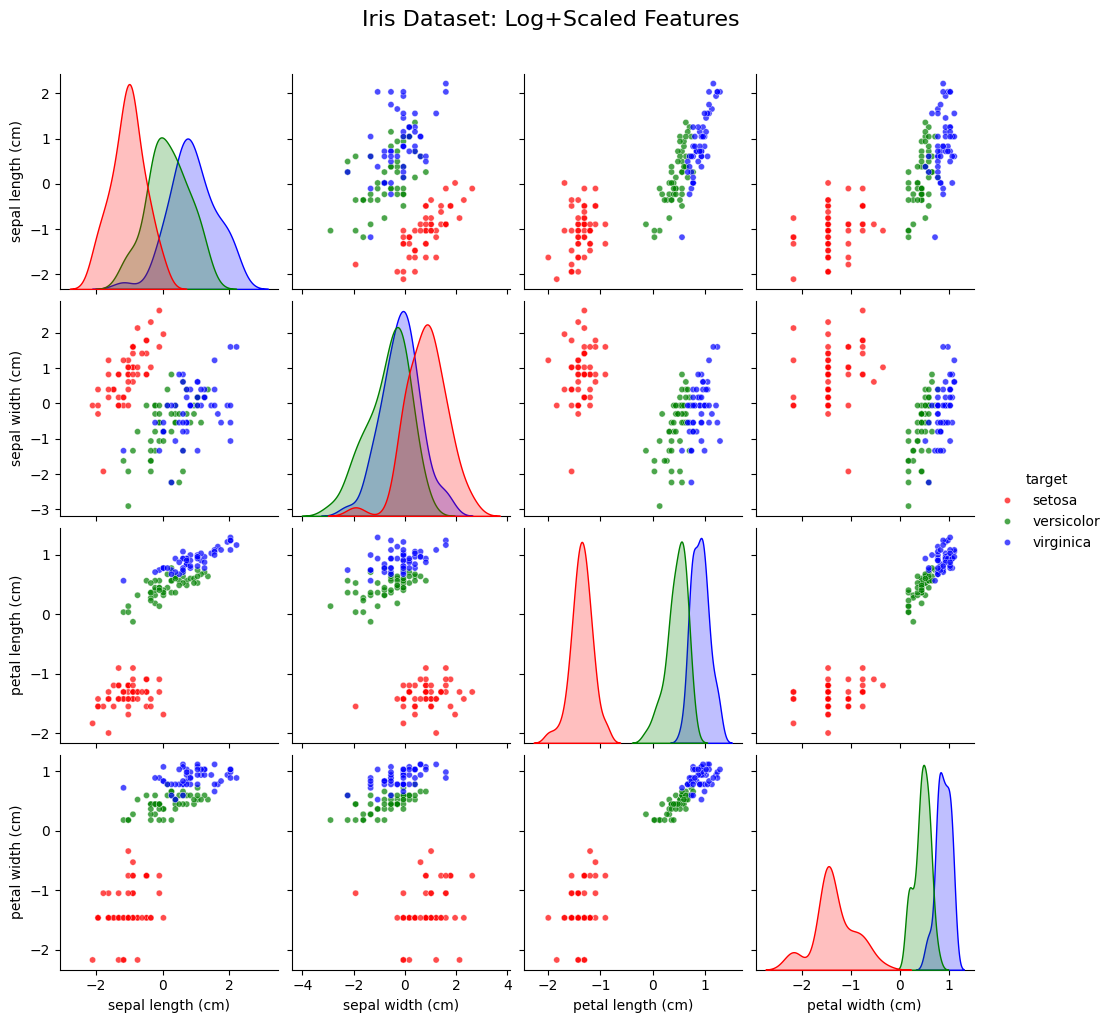

Text(0.5, 1.0, 'Iris Dataset: Log+Scaled Features - Correlation Matrix')

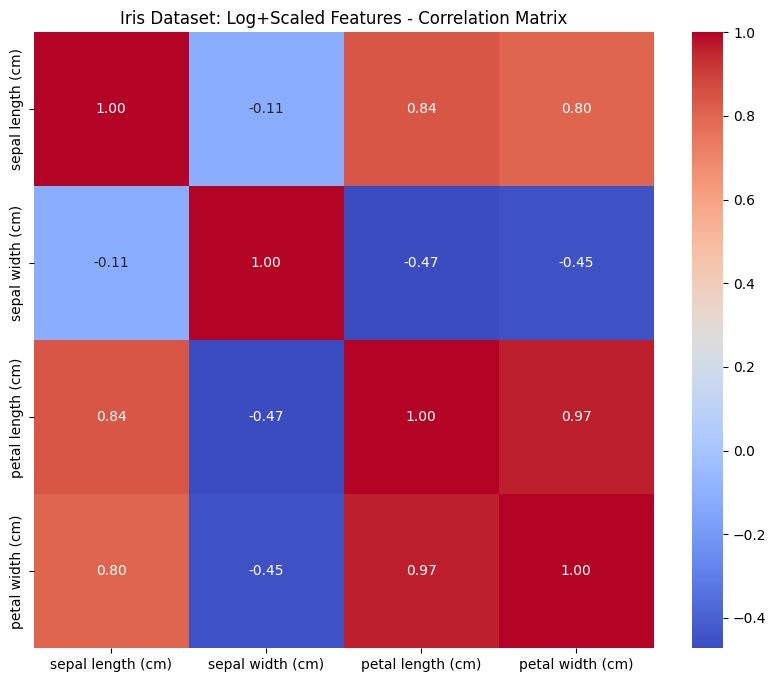

In [71]:
df_iris['type'] = 'Original'

# apply log transform to speparate the distributions
df_log_scaled = df_iris.copy()
df_log_scaled[iris_feature_names] = np.log(df_log_scaled[iris_feature_names] + 1e-10)  # for log(0)

# apply a standard scaling after log, on the features
scaler = StandardScaler()
df_log_scaled[iris_feature_names] = scaler.fit_transform(df_log_scaled[iris_feature_names])
df_log_scaled['type'] = 'Log+Scaled'
df_log_scaled['target'] = pd.Series(y_iris).map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})

# Combine both datasets
df_combined = pd.concat([df_iris, df_log_scaled], axis=0)

# Original data
g1 = sns.pairplot(df_iris, hue='target', vars=iris_feature_names, diag_kind='kde', palette={'setosa': 'red', 'versicolor': 'green', 'virginica': 'blue'}, plot_kws={'alpha': 0.7, 's': 20})
g1.fig.suptitle("Iris Dataset: Original Features", y=1.02, fontsize=16)

# Log+Scaled data  
g2 = sns.pairplot(df_log_scaled, hue='target', vars=iris_feature_names, diag_kind='kde', palette={'setosa': 'red', 'versicolor': 'green', 'virginica': 'blue'}, plot_kws={'alpha': 0.7, 's': 20})
g2.fig.suptitle("Iris Dataset: Log+Scaled Features", y=1.02, fontsize=16)

g1.tight_layout()
g2.tight_layout()
plt.show()

# Correlation Matrix for Log+Saled
corr_matrix_iris_log_scaled = df_log_scaled[iris_feature_names].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_iris_log_scaled, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Iris Dataset: Log+Scaled Features - Correlation Matrix')

### Classification 

In [72]:
# fix back the target labels for optimization
target_map = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
df_log_scaled['target'] = df_log_scaled['target'].map(target_map).astype(int)
df_log_scaled.info()
df_log_scaled.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   type               150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0          -0.896493          1.019375          -1.425759         -1.466867   
1          -1.180788         -0.061916          -1.425759         -1.466867   
2          -1.476932          0.390790          -1.551760         -1.466867   
3          -1.629764          0.168088          -1.308455         -1.466867   
4          -1.037219          1.216980          -1.425759         -1.466867   

   target        type  
0       0  Log+Scaled  
1       0  Log+Scaled  
2       0  Log+Scaled  
3       0  Log+Scaled  
4       0  Log+Scaled

In [73]:
feature_cols = [col for col in df_log_scaled.columns if col not in ['target', 'type']]
X = df_log_scaled[feature_cols].values  # extract the scaled and log-transformed feature data
y = df_log_scaled['target'].values  # integer labels 0,1,2
X_train, X_test, y_train, y_test = train_test_split(X_iris,y_iris,random_state=0)

print(X.shape)

(150, 4)


=== Model Evaluation ===
Test Accuracy: 0.9737


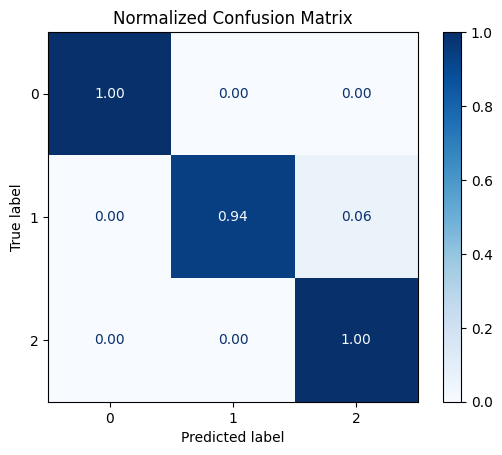

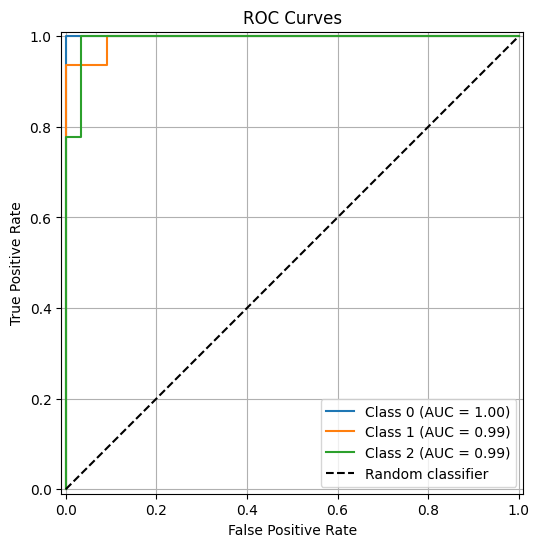

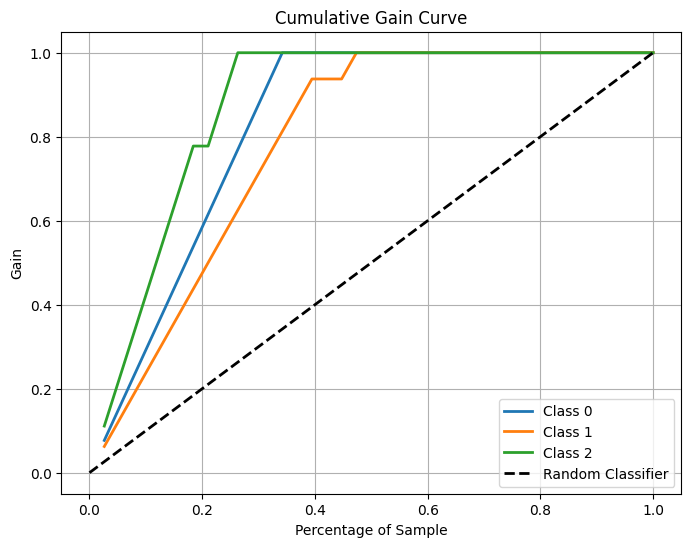

In [171]:
# Create a Network using YANNI
model = YANNI(
    ProblemType='classification',
    network_architecture=[4, 8, 3],               # [4, 5, 3] Input: 4, Hidden: 8, Output: 3
    activation_funcs=[ReLU_leaky, softmax_stable],    # Hidden: ReLU, Output: Softmax or softmaxstable
    learning_rate=0.05,                              #0.01
    optimizer='adam',                                 #momentum
    regularization='L1',
    lambdaVal=1e-4,
    momentum=0.9,                             
    batch_type='batch',                  
    max_iter=2000,                
    max_epoch=500,
    tol=1e-4
    # Here we use SDG, consider making the learning rate smaller or increasing the max_iter/epoch or lowering tol!
)

# Train
model.train(X_train, y_train, verbose=True)

# Evaluate
acc = model.evaluate_model(X_test, y_test, Plot=True)

### Test Binary: **Breast Cancer**

### Feature Processing

(569, 30)
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


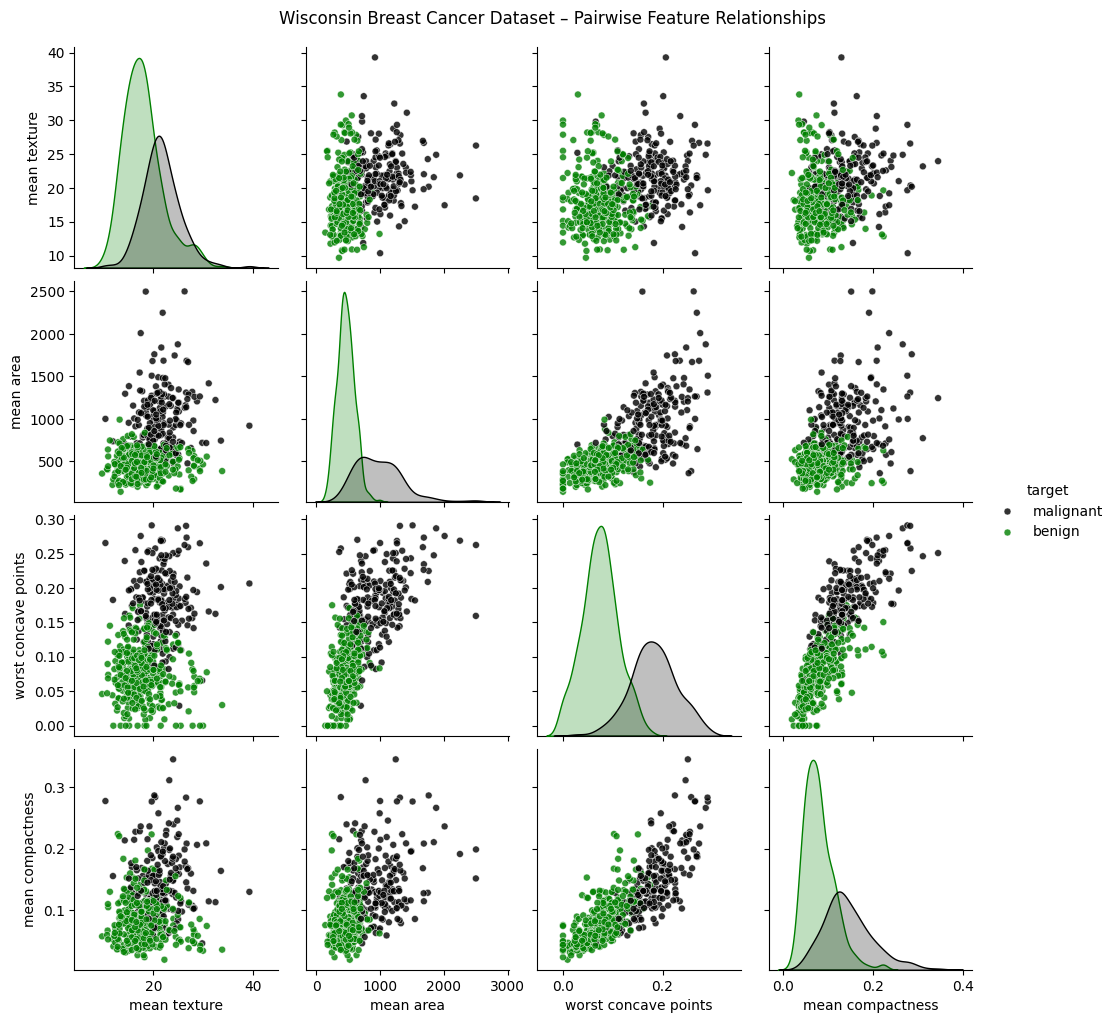

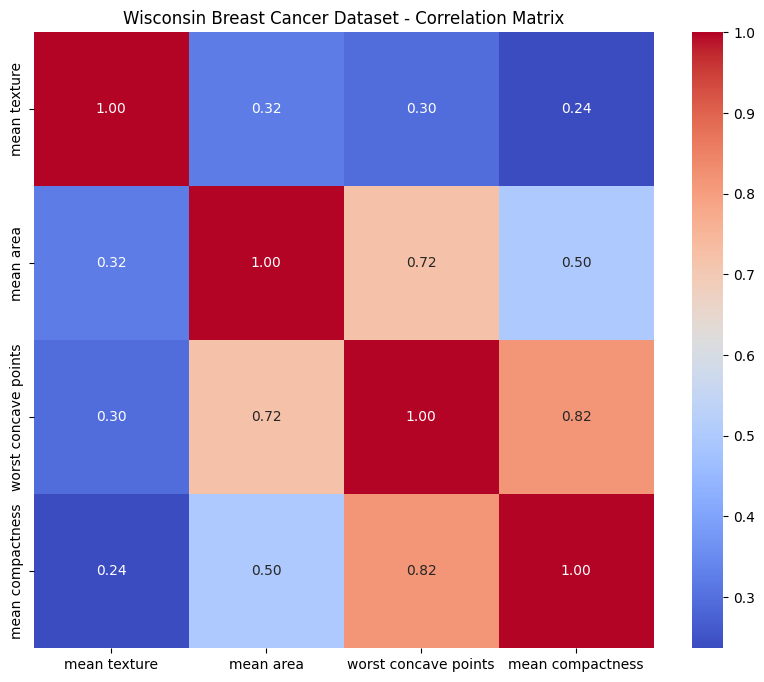

In [ ]:
wisconsin = load_breast_cancer()
X_cancer = wisconsin.data
y_cancer = wisconsin.target

cancer_features = wisconsin.feature_names
df_cancer = pd.DataFrame(X_cancer, columns=wisconsin.feature_names)

# Add target column with string labels
df_cancer['target'] = pd.Series(y_cancer).map({0: 'malignant', 1: 'benign'})

print(X_cancer.shape)
print(cancer_features)

# Subset of numeric features for pairplot
# subset_features = ['mean radius', 'mean perimeter', 'mean area', 'mean compactness/concavity']
subset_features_cancer = ['mean texture', 'mean area', 'worst concave points', 'mean compactness'] # have best preidcitve power and lowest correlation when grouped together

# Pairplot of raw data
sns.pairplot(df_cancer[subset_features_cancer + ['target']], hue='target', palette={'malignant': 'black', 'benign': 'green'}, diag_kind='kde', plot_kws={'alpha': 0.8, 's': 25})
plt.suptitle("Wisconsin Breast Cancer Dataset – Pairwise Feature Relationships", y=1.02)
plt.show()

corr_matrix_iris = df_cancer[subset_features_cancer].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_iris, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Wisconsin Breast Cancer Dataset - Correlation Matrix")
plt.show()

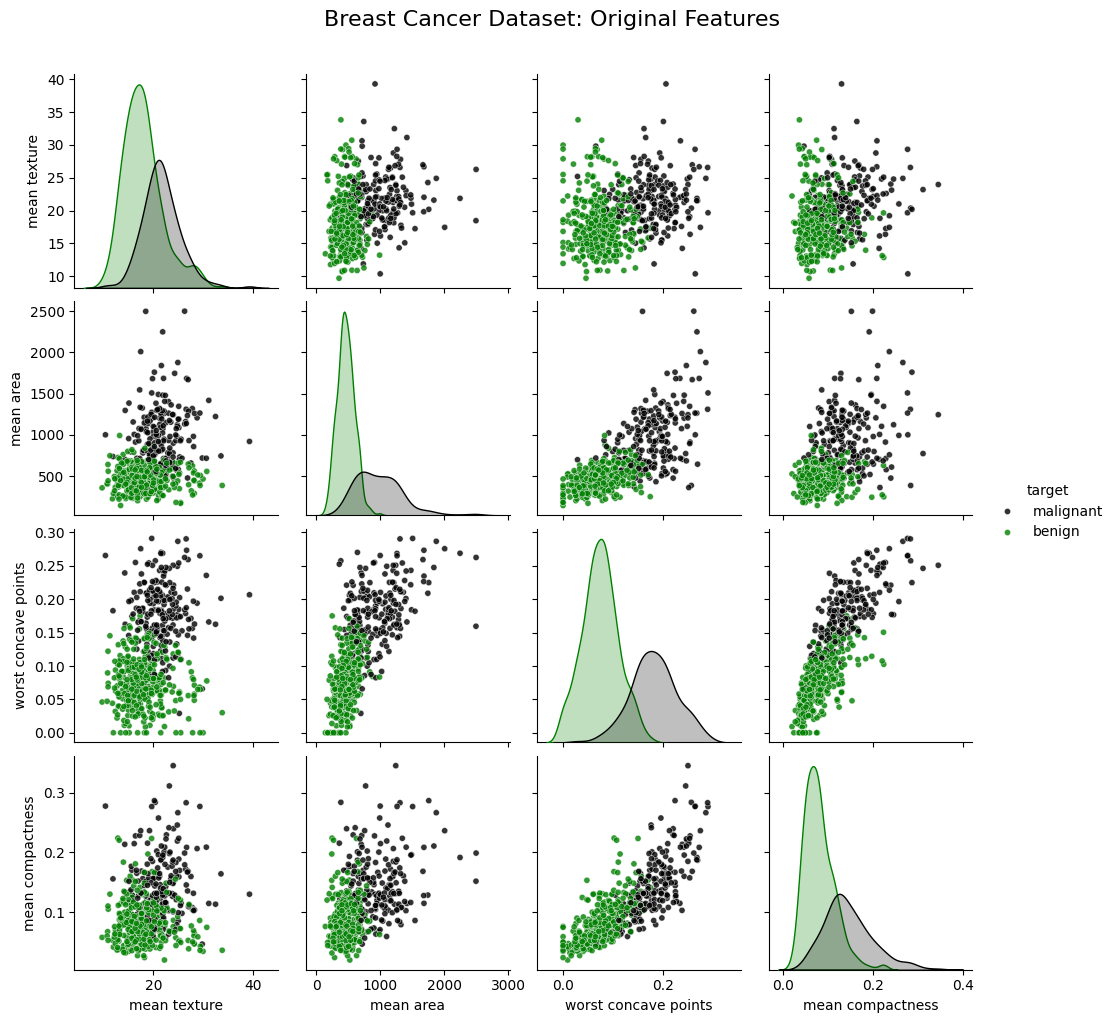

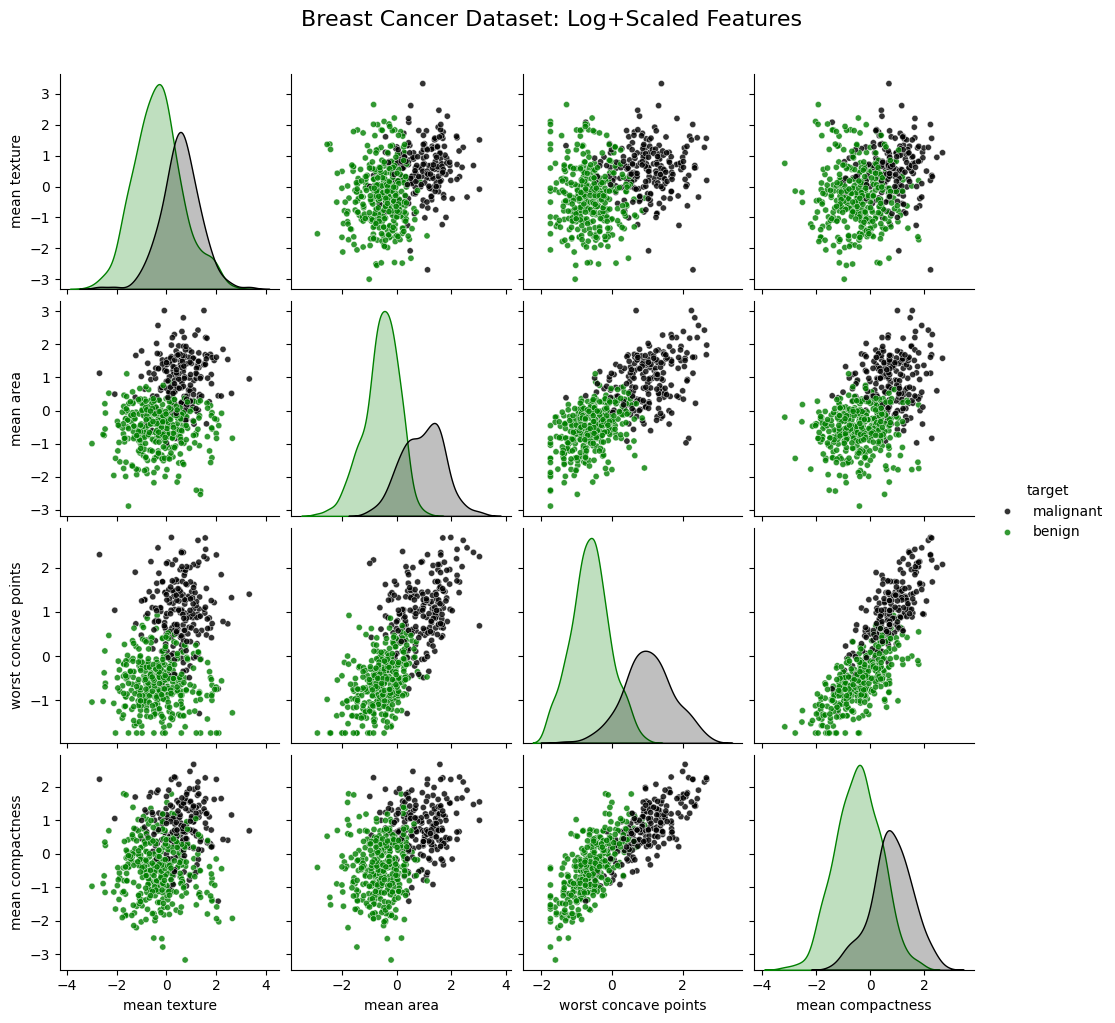

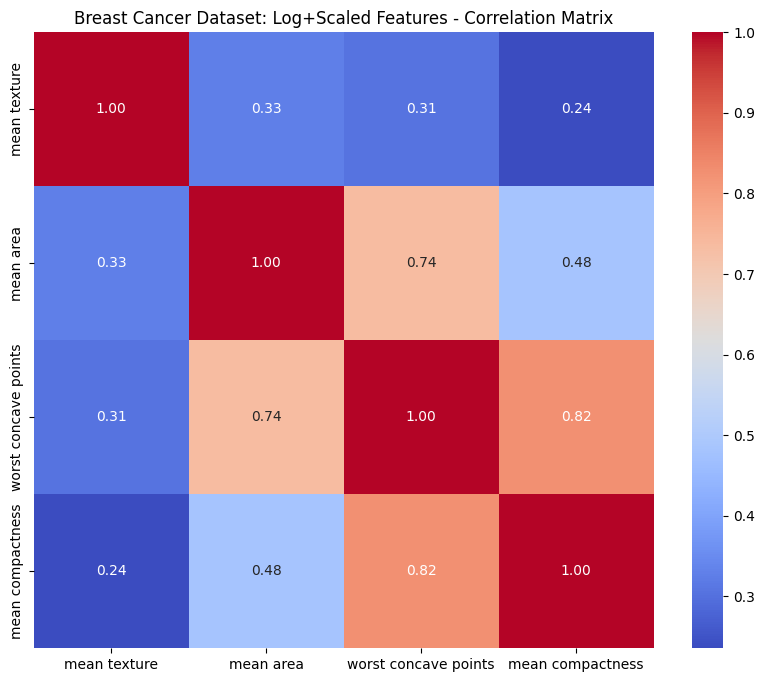

In [328]:
df_cancer['type'] = 'Original'

# Apply log transform to separate distributions
df_cancer_log_scaled = df_cancer[subset_features_cancer].copy() # copy the subset
for col in subset_features_cancer:
    if col != 'worst concave points':
        df_cancer_log_scaled[col] = np.log(df_cancer_log_scaled[col] + 1e-10)

# Apply standard scaling after log
scaler = StandardScaler()
df_cancer_log_scaled[subset_features_cancer] = scaler.fit_transform(df_cancer_log_scaled[subset_features_cancer])

df_cancer_log_scaled['type'] = 'Log+Scaled'
df_cancer_log_scaled['target'] = pd.Series(y_cancer).map({0: 'malignant', 1: 'benign'})

# Combine both datasets
df_cancer_combined = pd.concat([df_cancer, df_cancer_log_scaled], axis=0)

# Original data pairplot
g1 = sns.pairplot(df_cancer, hue='target', vars=subset_features_cancer, diag_kind='kde', palette={'malignant': 'black', 'benign': 'green'}, plot_kws={'alpha': 0.8, 's': 20})
g1.fig.suptitle("Breast Cancer Dataset: Original Features", y=1.02, fontsize=16)

# Log+Scaled data pairplot
g2 = sns.pairplot(df_cancer_log_scaled, hue='target', vars=subset_features_cancer, diag_kind='kde', palette={'malignant': 'black', 'benign': 'green'}, plot_kws={'alpha': 0.8, 's': 20})
g2.fig.suptitle("Breast Cancer Dataset: Log+Scaled Features", y=1.02, fontsize=16)

g1.tight_layout()
g2.tight_layout()
plt.show()

# Correlation matrix for Log+Scaled subset
corr_matrix_cancer_log_scaled = df_cancer_log_scaled[subset_features_cancer].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix_cancer_log_scaled, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Breast Cancer Dataset: Log+Scaled Features - Correlation Matrix')
plt.show()

### Classification (1 hidden layer):

In [329]:
target_map = {'malignant': 0, 'benign': 1}
df_cancer_log_scaled['target'] = df_cancer_log_scaled['target'].map(target_map).astype(int)
df_cancer_log_scaled.info()
display(df_cancer_log_scaled.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean texture          569 non-null    float64
 1   mean area             569 non-null    float64
 2   worst concave points  569 non-null    float64
 3   mean compactness      569 non-null    float64
 4   type                  569 non-null    object 
 5   target                569 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 26.8+ KB


mean texture  mean area  worst concave points  mean compactness  \
0     -2.699007   1.130212              2.296076          2.224472   
1     -0.261824   1.712684              1.087084         -0.328642   
2      0.548916   1.511015              1.955000          1.107862   
3      0.359416  -0.843332              2.175786          2.269896   
4     -1.234007   1.666874              0.729259          0.731961   

         type  target  
0  Log+Scaled       0  
1  Log+Scaled       0  
2  Log+Scaled       0  
3  Log+Scaled       0  
4  Log+Scaled       0

In [330]:
feature_cols_cancer = [col for col in df_cancer_log_scaled.columns if col not in ['target', 'type']]
X_cancer_sclog = df_cancer_log_scaled[feature_cols_cancer].values  # extract the scaled and log-transformed feature data
y_cancer_sclog = df_cancer_log_scaled['target'].values  # integer labels 0,1
X_train, X_test, y_train, y_test = train_test_split(X_cancer_sclog, y_cancer_sclog, random_state=0)
print(X_cancer_sclog.shape)

(569, 4)


=== Model Evaluation ===
Test Accuracy: 0.9510


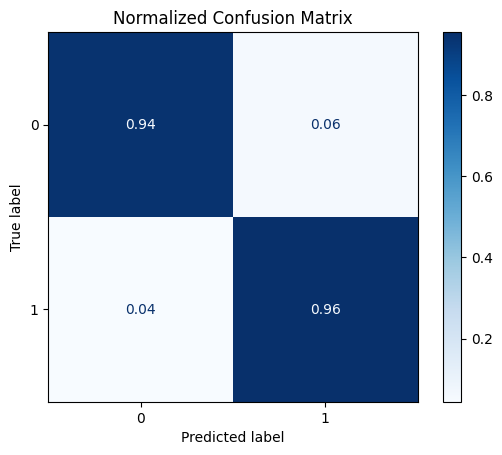

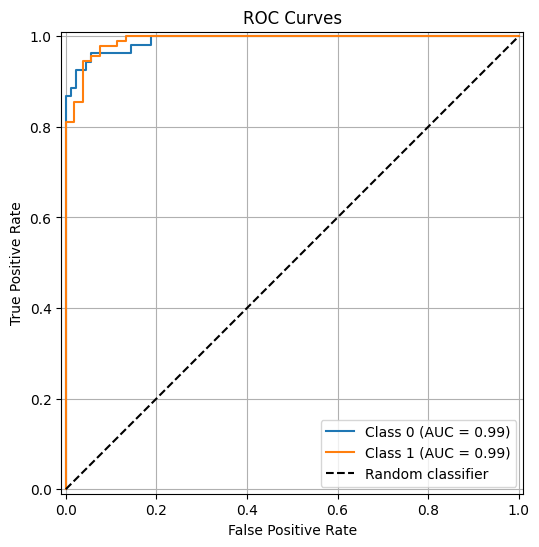

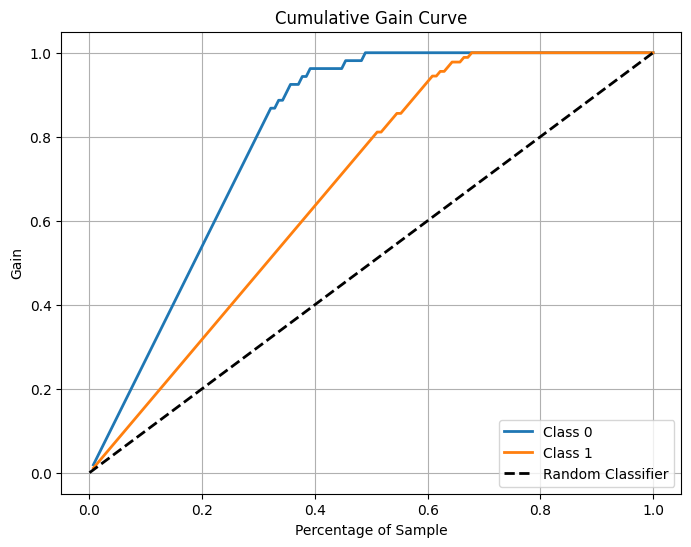

In [331]:
model = YANNI(
    ProblemType='classification',
    network_architecture=[X_cancer_sclog.shape[1], 10, 2],  # input=4, hidden layers 10+8, output=2
    activation_funcs=[ReLU_leaky, softmax_stable],    # last layer softmax
    learning_rate=0.05,
    optimizer='adam',
    regularization='L1',
    lambdaVal=1e-4,
    momentum=0.9,
    batch_type='batch',
    max_iter=2000,
    max_epoch=500,
    tol=1e-4
)

# Train
model.train(X_train, y_train, verbose=True)

# Evaluate
acc = model.evaluate_model(X_test, y_test, Plot=True)

### Classification: 3 hidden layers, stronger L1 regularzation

=== Model Evaluation ===
Test Accuracy: 0.9510


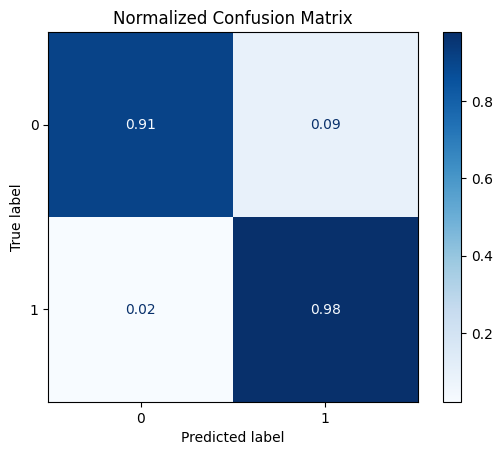

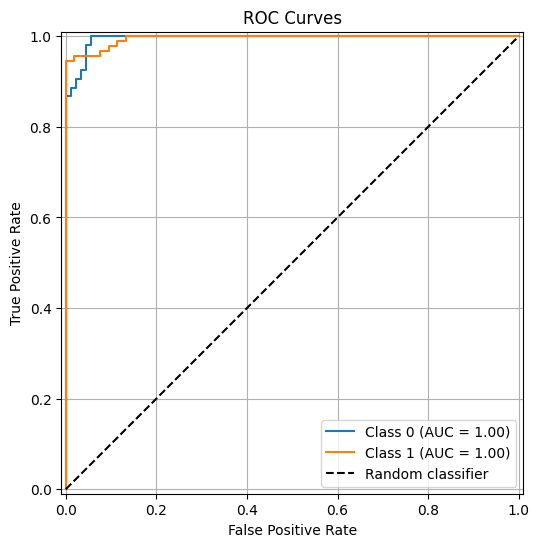

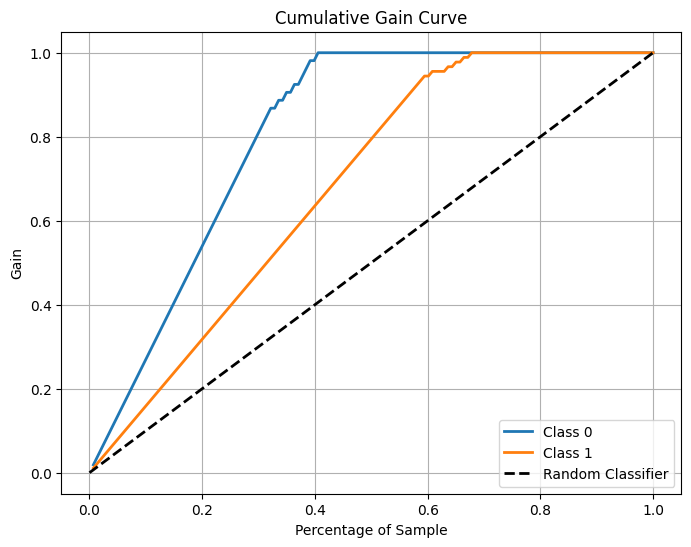

In [355]:
model = YANNI(
    ProblemType='classification',
    network_architecture=[X_cancer_sclog.shape[1], 40, 20, 6, 2],  # input=4, hidden layers 10+8, output=2
    activation_funcs=[ReLU_leaky, ReLU_leaky, ReLU_leaky, softmax_stable],    # last layer softmax
    learning_rate=0.05,
    optimizer='adam',
    regularization='L1',
    lambdaVal=5e-3,
    momentum=0.9,
    batch_type='batch',
    max_iter=2000,
    max_epoch=500,
    tol=1e-4
)

# Train
model.train(X_train, y_train, verbose=True)

# Evaluate
acc = model.evaluate_model(X_test, y_test, Plot=True)

### Classification: same architecture, using all 30 features (without log-transform)

=== Model Evaluation ===
Test Accuracy: 0.9650


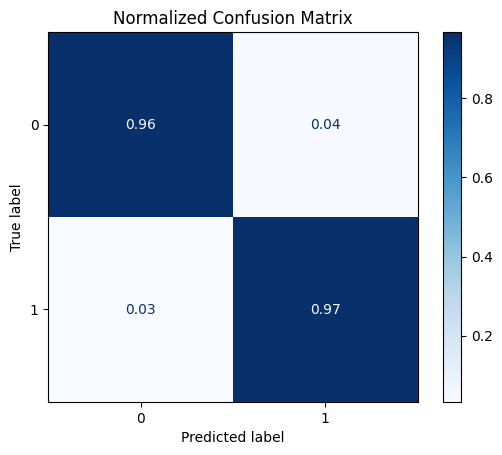

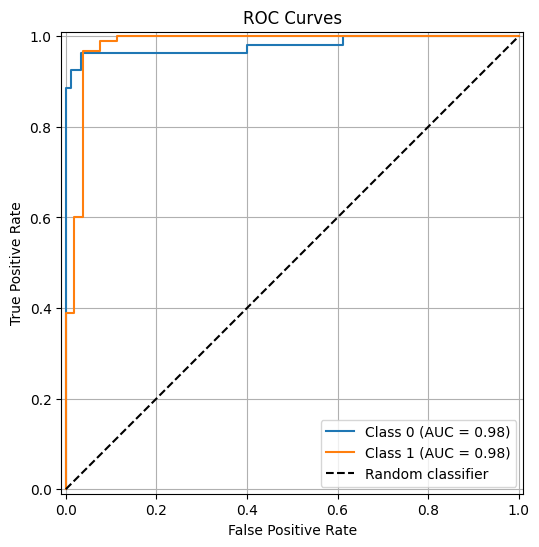

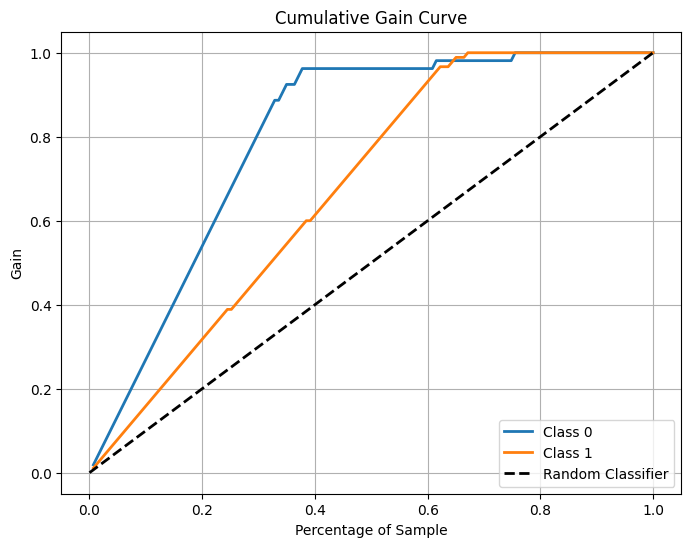

In [370]:
wisconsin = load_breast_cancer()
X_cancer = wisconsin.data
y_cancer = wisconsin.target
scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer)
X_train, X_test, y_train, y_test = train_test_split(X_cancer_scaled, y_cancer, random_state=0)
model = YANNI(
    ProblemType='classification',
    network_architecture=[X_cancer.shape[1], 40, 20, 6, 2],  # input=4, hidden layers 10+8, output=2
    activation_funcs=[ReLU_leaky, ReLU_leaky, ReLU_leaky, softmax_stable],    # last layer softmax
    learning_rate=0.05,
    optimizer='adam',
    regularization='L1',
    lambdaVal=5e-3,
    momentum=0.9,
    batch_type='batch',
    max_iter=2000,
    max_epoch=500,
    tol=1e-4
)

# Train
model.train(X_train, y_train, verbose=True)

# Evaluate
acc = model.evaluate_model(X_test, y_test, Plot=True)

# REGRESSION 

### Exploring: (adaptive optimizer, batch mode, Runge(x, $\sigma$), Network Architecture, no regularization)

In [ ]:
def runge_function(N, noise=True, stdev=0.5):
    '''
    define runge function in the given interval with stochastic noise following N(0,sigma)
    sigma is a variable we use 0.1, 0.3, 0.5, 0.8, 1
    returns x and y vectors of size N
    '''
    x = np.linspace(-1, 1, N)
    y = 1/(1+25*x**2) 
    if noise:
        y += np.random.normal(0, stdev, size=N) 
    return x.reshape(-1,1), y.reshape(-1,1) # ensure column vectors

def pre_processing(x, y, test_ratio=0.2):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=42)
    
    # Save unscaled versions for plotting
    x_train, x_test = X_train.copy(), X_test.copy()

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Remove mean offset from y
    y_offset = np.mean(y_train, axis=0)
    y_train_scaled = y_train - y_offset
    
    # Maximal eigenvalue of Hessian (for learning rate heuristics)
    H = (2.0/X_train_scaled.shape[0]) * X_train_scaled.T @ X_train_scaled
    max_eig = np.max(np.linalg.eigvals(H))
    
    return X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, max_eig

def fit_ols(x_train, x_test, y_train, P):
    '''
    Fit OLS with polynomial features of degree P
    '''
    poly = PolynomialFeatures(degree=P, include_bias=False)
    X_poly_train = poly.fit_transform(x_train.reshape(-1, 1))
    X_poly_test = poly.transform(x_test.reshape(-1, 1))
    
    poly_scaler = StandardScaler()
    X_poly_train_scaled = poly_scaler.fit_transform(X_poly_train)
    X_poly_test_scaled = poly_scaler.transform(X_poly_test)
    
    # Add bias term
    X_poly_train_scaled = np.hstack([np.ones((X_poly_train_scaled.shape[0], 1)), X_poly_train_scaled])
    X_poly_test_scaled = np.hstack([np.ones((X_poly_test_scaled.shape[0], 1)), X_poly_test_scaled])
    
    # Fit using OLS equations and numpy Pinverse
    theta = np.linalg.pinv(X_poly_train_scaled.T @ X_poly_train_scaled) @ X_poly_train_scaled.T @ y_train
    
    y_pred_train = X_poly_train_scaled @ theta
    y_pred_test = X_poly_test_scaled @ theta
    
    return y_pred_train, y_pred_test

### NN using Tensorflow and Keras.trial

compatible with ranges for parameters. You choose a number of random selections of attributes (trials) and then optimize the network



In [139]:
class RungeHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()

        # choose effective architecture
        for i in range(hp.Int('num_layers', 1, 4)):
            units=hp.Int(f'units_{i}', min_value=10, max_value=200, step=50)
            activation=hp.Choice('activation', ['relu', 'sigmoid'])
            model.add(Dense(units=units, activation=activation))
        model.add(Dense(1, activation='linear')) # output layer
        
        # Choose optimizer adam/rmsprop and optimal learning rate
        # optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        # if optimizer_choice == 'adam':
        #     optimizer = Adam(learning_rate=lr)
        # else:
        #     optimizer = RMSprop(learning_rate=lr)
        # model.compile(optimizer=optimizer, loss='mse')

        # Fix optimizer vary learning rate, no regularuzation
        learning_rate = hp.Float('learning_rate', 1e-3, 1e-1, sampling='log')
        optimizer = Adam(learning_rate=learning_rate)

        model.compile(optimizer=optimizer, loss='mse')
        return model

In [78]:
# Generate Runge data
N = 1000
stdev=0.3
x, y = runge_function(N, noise=True, stdev=stdev)
X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, max_eig = pre_processing(x, y)

### test with ADAM, no regularization, batch mode, 2 hidden layers

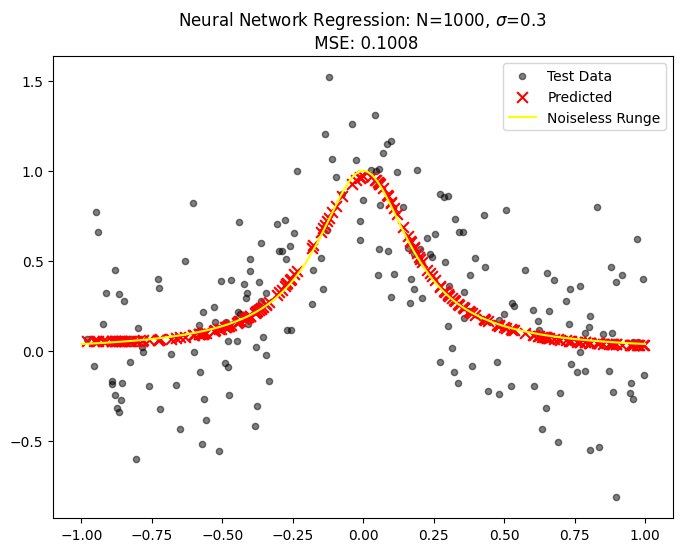

In [79]:
# Build Neural Network
model = YANNI(
    ProblemType='regression',
    network_architecture=[1, 50, 100, 1],
    activation_funcs=[sigmoid, sigmoid, linear],  # linear output
    learning_rate=0.01,
    optimizer='adam',
    regularization=None,
    lambdaVal=0.0,
    batch_type='batch',  # full batch for regression
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)

# Train
model.train(X_train_scaled, y_train_scaled)

# Evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_pred_scaled + y_offset  # add offset back
# Compute MSE on test set
mse_test = np.mean((y_test - y_pred)**2)

plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data', s=20, color='black',alpha=0.5)
plt.scatter(x_test, y_pred, label='Predicted', color='red', marker='x', s=60, alpha=1)

plot_xaxis2, plot_yaxis2 = runge_function(N, False)
x_gauss = np.linspace(-1, 1, 500)
sigma = 0.15
gaussian = np.exp(-x_gauss**2 / (2 * sigma**2))
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')
# plt.plot(x_gauss, gaussian, label=rf'Gaussian $\sigma$={sigma}', color='cyan')

plt.title(f"Neural Network Regression: N={N}, $\sigma$={stdev} \n MSE: {mse_test:.4f}")
plt.legend()
# plt.savefig(rf"{figpath}\Regression_N={N}_sigma={stdev}.png")
plt.show()

### Test YANNI against OLS standard lib LinReg and Keras/Tensorflow selection

In [157]:
N_values = [100, 500, 1000, 1500, 2000]
stdev = 0.3
P = 12

# Results Storage
nn_test_mses = []
ols_test_mses = []
nn_train_mses = []
ols_train_mses = []
tf_train_mses = []
tf_test_mses = []

for N in N_values:
    print(f"\nTesting N = {N}")
    
    # Generate data
    x, y = runge_function(N, noise=False, stdev=stdev)
    
    # Preprocessing
    X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, _ = pre_processing(x, y)
    
    model = YANNI(
        ProblemType='regression',
        network_architecture=[1, 50, 100, 1],
        activation_funcs=[sigmoid, sigmoid, linear],
        learning_rate=0.05,
        optimizer='adam',
        regularization=None,
        lambdaVal=0.0,
        batch_type='batch',
        max_iter=2000,
        max_epoch=500,
        tol=1e-5
    )

    tuner = RandomSearch(
        RungeHyperModel(),
        objective='val_loss',
        max_trials=5,   # Try 5 different configurations
        executions_per_trial=1,
        overwrite=True,
        directory='tuner_results',
        project_name=f'runge_{N}'
    )
    
    model.train(X_train_scaled, y_train_scaled)
    
    # NN predictions
    y_pred_train_nn = model.predict(X_train_scaled) + y_offset
    y_pred_test_nn = model.predict(X_test_scaled) + y_offset
    nn_train_mse = mean_squared_error(y_train_scaled + y_offset, y_pred_train_nn)
    nn_test_mse = mean_squared_error(y_test, y_pred_test_nn)
    
    # OLS Polynomial LinReg
    y_pred_train_ols, y_pred_test_ols = fit_ols(x_train, x_test, y_train_scaled + y_offset, P=P)
    ols_train_mse = mean_squared_error(y_train_scaled + y_offset, y_pred_train_ols)
    ols_test_mse = mean_squared_error(y_test, y_pred_test_ols)
    
    # Store results
    nn_train_mses.append(nn_train_mse)
    nn_test_mses.append(nn_test_mse)
    ols_train_mses.append(ols_train_mse)
    ols_test_mses.append(ols_test_mse)

    # TensorFlow (Keras) NN  (reduced epoch (make fixed NN more compatible )and trials runs, for runtime)
    tuner.search(X_train_scaled, y_train_scaled, validation_split=0.2, epochs=100, batch_size=32, verbose=0)
    best_model = tuner.get_best_models(num_models=1)[0]
    X_train_scaled = np.asarray(X_train_scaled).astype(np.float32)
    X_test_scaled = np.asarray(X_test_scaled).astype(np.float32)
    y_pred_train_tf = best_model.predict(X_train_scaled).flatten() + y_offset
    y_pred_test_tf = best_model.predict(X_test_scaled).flatten() + y_offset
    tf_train_mse = mean_squared_error(y_train_scaled + y_offset, y_pred_train_tf)
    tf_test_mse = mean_squared_error(y_test, y_pred_test_tf)
    tf_train_mses.append(tf_train_mse)
    tf_test_mses.append(tf_test_mse)

    print(f"NN - Train MSE: {nn_train_mse:.4f}, Test MSE: {nn_test_mse:.8f}")
    print(f"OLS - Train MSE: {ols_train_mse:.4f}, Test MSE: {ols_test_mse:.8f}")
    print(f"TF(K) - Train MSE: {tf_train_mse:.4f}, Test MSE: {tf_test_mse:.8f}")


Testing N = 100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


c:\DATA_ANALYSIS_TEST\simpleTEst.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


NN - Train MSE: 0.0000, Test MSE: 0.00000712
OLS - Train MSE: 0.0007, Test MSE: 0.00123010
TF(K) - Train MSE: 0.0000, Test MSE: 0.00004665

Testing N = 500
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

c:\DATA_ANALYSIS_TEST\simpleTEst.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
NN - Train MSE: 0.0000, Test MSE: 0.00000298
OLS - Train MSE: 0.0008, Test MSE: 0.00060885
TF(K) - Train MSE: 0.0000, Test MSE: 0.00000307

Testing N = 1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


c:\DATA_ANALYSIS_TEST\simpleTEst.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


NN - Train MSE: 0.0000, Test MSE: 0.00000508
OLS - Train MSE: 0.0007, Test MSE: 0.00069593
TF(K) - Train MSE: 0.0000, Test MSE: 0.00000335

Testing N = 1500


c:\DATA_ANALYSIS_TEST\simpleTEst.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
NN - Train MSE: 0.0000, Test MSE: 0.00002649
OLS - Train MSE: 0.0007, Test MSE: 0.00066626
TF(K) - Train MSE: 0.0000, Test MSE: 0.00000030

Testing N = 2000
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


c:\DATA_ANALYSIS_TEST\simpleTEst.venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


NN - Train MSE: 0.0000, Test MSE: 0.00002644
OLS - Train MSE: 0.0007, Test MSE: 0.00059233
TF(K) - Train MSE: 0.0000, Test MSE: 0.00000369


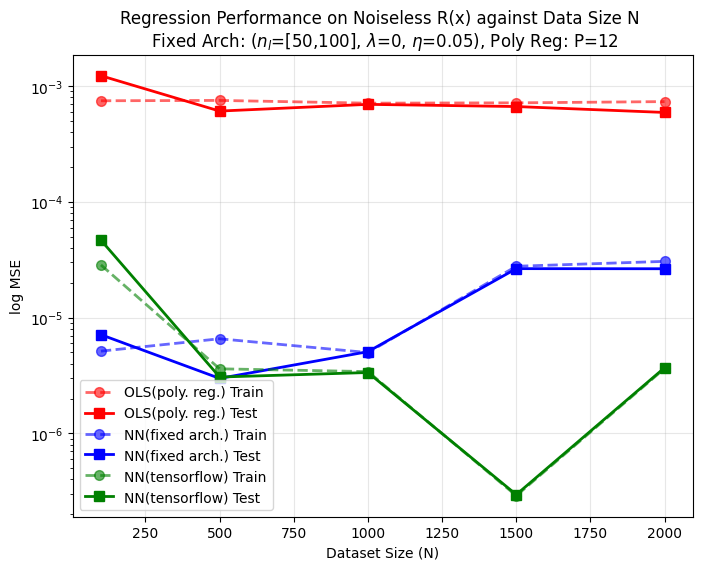

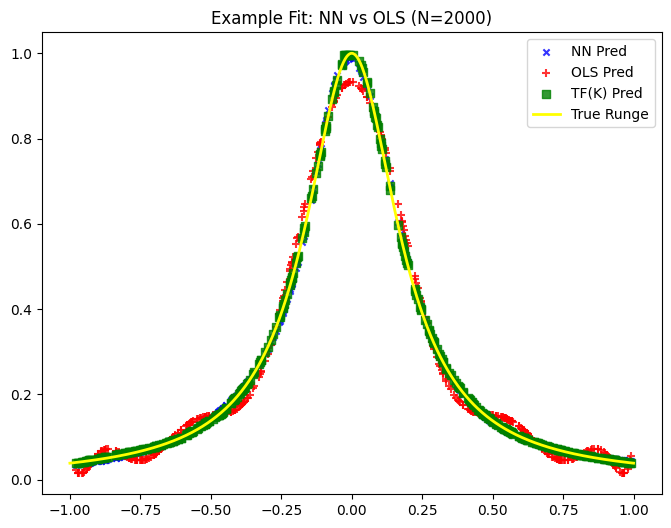

In [158]:
# Plot 1: Train vs Test MSE
plt.figure(figsize=(8, 6))
plt.semilogy(N_values, ols_train_mses, 'r', linestyle='--', marker='o', label='OLS(poly. reg.) Train', linewidth=2, markersize=7, alpha=0.6)
plt.semilogy(N_values, ols_test_mses, 'r', linestyle='-', marker='s', label='OLS(poly. reg.) Test', linewidth=2, markersize=7)
plt.semilogy(N_values, nn_train_mses, 'b', linestyle='--', marker='o', label='NN(fixed arch.) Train', linewidth=2, markersize=7, alpha=0.6)
plt.semilogy(N_values, nn_test_mses, 'b', linestyle='-', marker='s', label='NN(fixed arch.) Test', linewidth=2, markersize=7)
plt.semilogy(N_values, tf_train_mses, 'g', linestyle='--', marker='o', label='NN(tensorflow) Train', linewidth=2, markersize=7, alpha=0.6)
plt.semilogy(N_values, tf_test_mses, 'g', linestyle='-', marker='s', label='NN(tensorflow) Test', linewidth=2, markersize=7)

plt.xlabel('Dataset Size (N)')
plt.ylabel('log MSE')
plt.title(f"Regression Performance on Noiseless R(x) against Data Size N \n Fixed Arch: ($n_l$=[50,100], $\lambda$=0, $\eta$=0.05), Poly Reg: P={P}")
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig("Train_Test_MSE_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Example fit for largest N
plt.figure(figsize=(8, 6))
plot_x, plot_y_true = runge_function(1000, False)
# plt.scatter(x_test, y_test, label='Test Data', s=10, color='black', alpha=0.5)
plt.scatter(x_test, y_pred_test_nn, label='NN Pred', color='blue', marker='x', s=20, alpha=0.8)
plt.scatter(x_test, y_pred_test_ols, label='OLS Pred', color='red', marker='+', s=30, alpha=0.8)
plt.scatter(x_test, y_pred_test_tf, label='TF(K) Pred', color='green', marker='s', s=30, alpha=0.8)
plt.plot(plot_x, plot_y_true, label='True Runge', color='yellow', linewidth=2)
# plt.xlabel('x')
# plt.ylabel('y')
plt.title(f'Example Fit: NN vs OLS (N={N})')
plt.legend()
# plt.savefig(f"Example_Fit_N={N}.png", dpi=300, bbox_inches='tight')
plt.show()

### Test NN architecture and optimization with 2D heatmaps

In [190]:
N = 1000
stdev=0.3
x, y = runge_function(N, noise=True, stdev=stdev)
X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, max_eig = pre_processing(x, y)

### Test A (architecture)

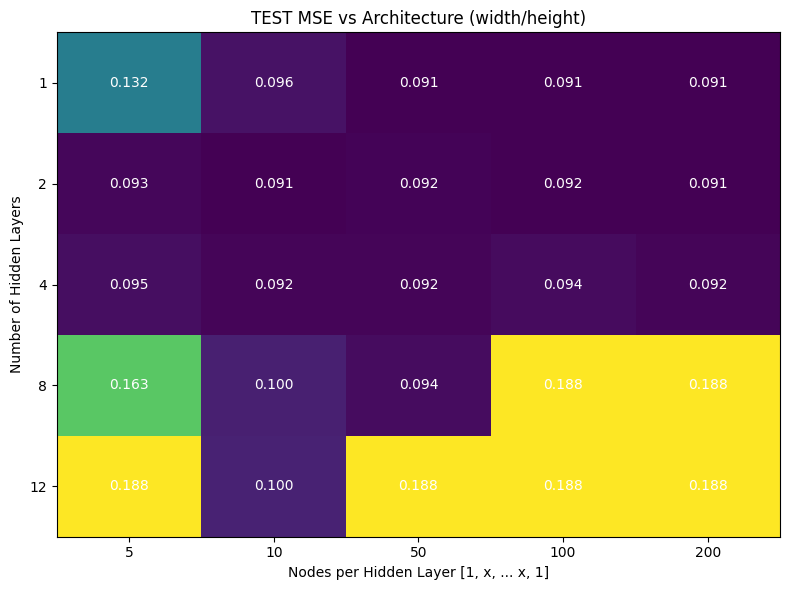

In [ ]:
# Define parameter ranges
widths = [1, 2, 4, 8, 12]  # number of hidden layers
node_sizes = [5, 10, 50, 100, 200]  # nodes per hidden layer

# Store results
test_mses_a = np.zeros((len(widths), len(node_sizes)))

for i, width in enumerate(widths):
    for j, nodes in enumerate(node_sizes):
        # Build architecture: [1, nodes, nodes, ..., 1]
        architecture = [1] + [nodes] * width + [1]
        activation_funcs = [sigmoid] * width + [linear]
               
        model = YANNI(
            ProblemType='regression',
            network_architecture=architecture,
            activation_funcs=activation_funcs,
            learning_rate=0.01,
            optimizer='adam',
            regularization=None,
            lambdaVal=0.0,
            batch_type='batch',
            max_iter=2000,
            max_epoch=500,
            tol=1e-5
        )
        
        model.train(X_train_scaled, y_train_scaled)
        y_pred_test = model.predict(X_test_scaled) + y_offset
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_mses_a[i, j] = test_mse

# Plot Test A
plt.figure(figsize=(8, 6))
im = plt.imshow(test_mses_a, cmap='viridis', aspect='auto')
plt.xticks(np.arange(len(node_sizes)), node_sizes)
plt.yticks(np.arange(len(widths)), widths)
plt.xlabel('Nodes per Hidden Layer [1, x, ... x, 1]')
plt.ylabel('Number of Hidden Layers')
plt.title('TEST MSE vs Architecture (width/height)')

for i in range(len(widths)):
    for j in range(len(node_sizes)):
        plt.text(j, i, f'{test_mses_a[i, j]:.3f}', ha="center", va="center", color="w")

plt.colorbar(im)
plt.tight_layout()
plt.savefig("Architecture_Heatmap_N=1000.png", dpi=300, bbox_inches='tight')
plt.show()

### Test B: Optimization Hyperparamters (L2)

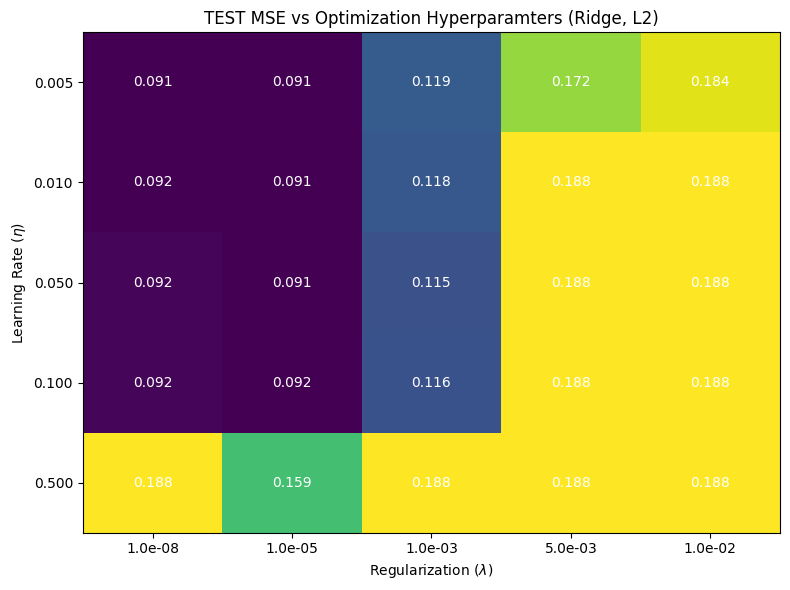

In [ ]:
# Define parameter ranges
learning_rates = [0.005, 0.01, 0.05, 0.1, 0.5]
lambda_vals = [1e-8, 1e-5, 1e-3, 5e-3, 1e-2]

# Fixed architecture (use reasonable default)
architecture = [1, 50, 100, 1]
activation_funcs = [sigmoid, sigmoid, linear]

# Store results
test_mses_b = np.zeros((len(learning_rates), len(lambda_vals)))

for i, lr in enumerate(learning_rates):
    for j, lambda_val in enumerate(lambda_vals):

        model = YANNI(
            ProblemType='regression',
            network_architecture=architecture,
            activation_funcs=activation_funcs,
            learning_rate=lr,
            optimizer='adam',
            regularization='L2' if lambda_val > 0 else None,
            lambdaVal=lambda_val,
            batch_type='batch',
            max_iter=2000,
            max_epoch=500,
            tol=1e-5
        )
        
        model.train(X_train_scaled, y_train_scaled)
        y_pred_test = model.predict(X_test_scaled) + y_offset
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_mses_b[i, j] = test_mse

# Plot Test B
plt.figure(figsize=(8, 6))
im = plt.imshow(test_mses_b, cmap='viridis', aspect='auto')
plt.xticks(np.arange(len(lambda_vals)), [f'{lv:.1e}' for lv in lambda_vals])
plt.yticks(np.arange(len(learning_rates)), [f'{lr:.3f}' for lr in learning_rates])
plt.xlabel(f'Regularization ($\lambda$)')
plt.ylabel(f'Learning Rate ($\eta$)')
plt.title('TEST MSE vs Optimization Hyperparamters (Ridge, L2)')

for i in range(len(learning_rates)):
    for j in range(len(lambda_vals)):
        plt.text(j, i, f'{test_mses_b[i, j]:.3f}', ha="center", va="center", color="w")

plt.colorbar(im)
plt.tight_layout()
plt.savefig("LR_vs_Regularization_Heatmap_N=1000.png", dpi=300, bbox_inches='tight')
plt.show()

### Test C: Optimization Hyperparamters (L1)

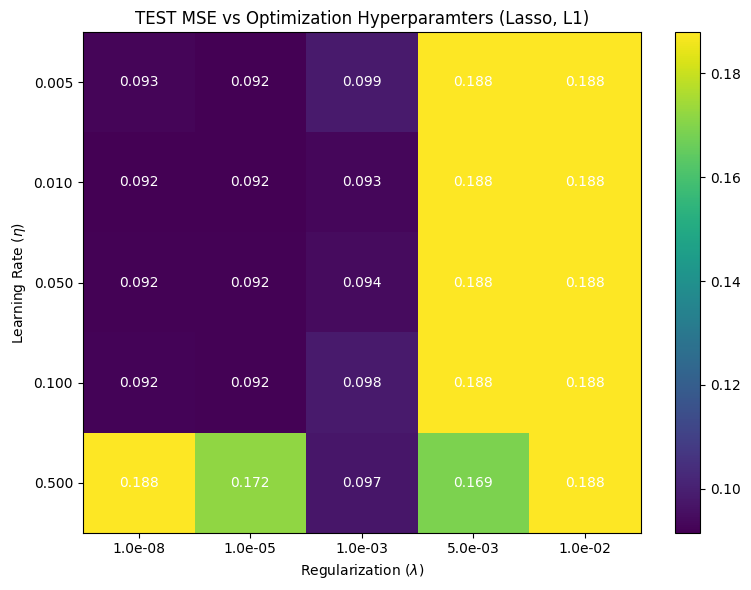

In [173]:
# Define parameter ranges
learning_rates = [0.005, 0.01, 0.05, 0.1, 0.5]
lambda_vals = [1e-8, 1e-5, 1e-3, 5e-3, 1e-2]

# Fixed architecture (use reasonable default)
architecture = [1, 50, 100, 1]
activation_funcs = [sigmoid, sigmoid, linear]

# Store results
test_mses_b = np.zeros((len(learning_rates), len(lambda_vals)))

for i, lr in enumerate(learning_rates):
    for j, lambda_val in enumerate(lambda_vals):

        model = YANNI(
            ProblemType='regression',
            network_architecture=architecture,
            activation_funcs=activation_funcs,
            learning_rate=lr,
            optimizer='adam',
            regularization='L1' if lambda_val > 0 else None,
            lambdaVal=lambda_val,
            batch_type='batch',
            max_iter=2000,
            max_epoch=500,
            tol=1e-5
        )
        
        model.train(X_train_scaled, y_train_scaled)
        y_pred_test = model.predict(X_test_scaled) + y_offset
        test_mse = mean_squared_error(y_test, y_pred_test)
        test_mses_b[i, j] = test_mse

# Plot Test B
plt.figure(figsize=(8, 6))
im = plt.imshow(test_mses_b, cmap='viridis', aspect='auto')
plt.xticks(np.arange(len(lambda_vals)), [f'{lv:.1e}' for lv in lambda_vals])
plt.yticks(np.arange(len(learning_rates)), [f'{lr:.3f}' for lr in learning_rates])
plt.xlabel(f'Regularization ($\lambda$)')
plt.ylabel(f'Learning Rate ($\eta$)')
plt.title('TEST MSE vs Optimization Hyperparamters (Lasso, L1)')

for i in range(len(learning_rates)):
    for j in range(len(lambda_vals)):
        plt.text(j, i, f'{test_mses_b[i, j]:.3f}', ha="center", va="center", color="w")

plt.colorbar(im)
plt.tight_layout()
plt.savefig("LR_vs_Regularization_Heatmap_N=1000.png", dpi=300, bbox_inches='tight')
plt.show()

### Test with ADAM, no regularization, batch mode, *1* hidden layer

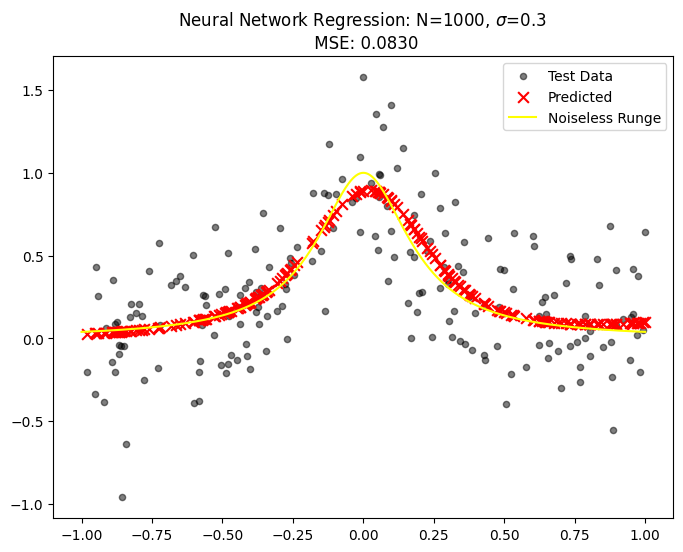

In [165]:
# Build Neural Network
model = YANNI(
    ProblemType='regression',
    network_architecture=[1, 50, 1],
    activation_funcs=[sigmoid, linear],  # linear output
    learning_rate=0.01,
    optimizer='adam',
    regularization=None,
    lambdaVal=0.0,
    batch_type='batch',  # full batch for regression
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)

# Train
model.train(X_train_scaled, y_train_scaled)

# Evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_pred_scaled + y_offset  # add offset back
# Compute MSE on test set
mse_test = np.mean((y_test - y_pred)**2)

plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data', s=20, color='black',alpha=0.5)
plt.scatter(x_test, y_pred, label='Predicted', color='red', marker='x', s=60, alpha=1)

plot_xaxis2, plot_yaxis2 = runge_function(N, False)
x_gauss = np.linspace(-1, 1, 500)
sigma = 0.15
gaussian = np.exp(-x_gauss**2 / (2 * sigma**2))
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')
# plt.plot(x_gauss, gaussian, label=rf'Gaussian $\sigma$={sigma}', color='cyan')

plt.title(f"Neural Network Regression: N={N}, $\sigma$={stdev} \n MSE: {mse_test:.4f}")
plt.legend()
plt.show()

### Compare RMSProp/ADAM/VanillaGD, SDG/BATCH


-> Training model: Adam (Batch, (LR=0.05)

-> Training model: RMSProp (Batch, (LR=0.008)

-> Training model: Vanilla GD (Batch, (LR=0.008)

-> Training model: Adam (SGD, (LR=0.008)


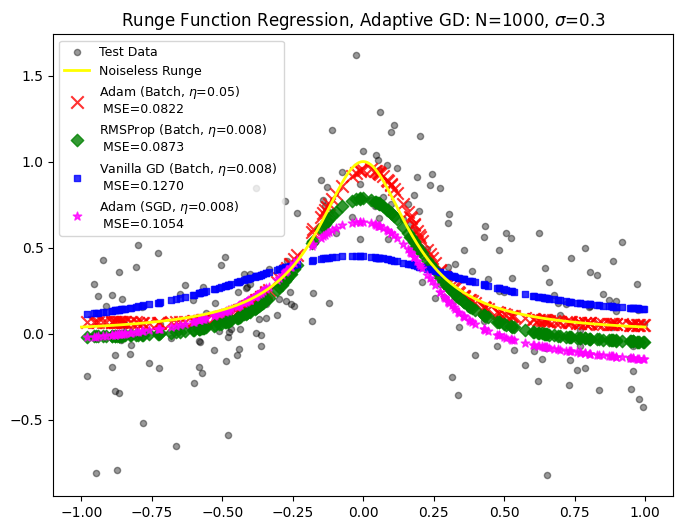

In [239]:
# Define optimizer–batch configurations
configs = [
    ("Adam (Batch,", "adam", "batch"),
    ("RMSProp (Batch,", "rmsprop", "batch"),
    ("Vanilla GD (Batch,", "vanilla", "batch"),
    ("Adam (SGD,", "adam", "stochastic")
]

# Corresponding learning rates (one per config)
learning_rates = [0.05, 0.008, 0.008, 0.008]
epochs = [500, 500, 1000, 1000]
# Store results 
results = {}

for (label, opt, batch_type), lr, epoch in zip(configs, learning_rates, epochs):
    print(f"\n-> Training model: {label} (LR={lr})")

    model = YANNI(
        ProblemType='regression',
        network_architecture=[1, 50, 100, 1],
        activation_funcs=[sigmoid, sigmoid, linear],
        learning_rate=lr,
        optimizer=opt,
        regularization=None,
        lambdaVal=0.0,
        batch_type=batch_type,
        max_iter=2000,
        max_epoch=epoch,
        tol=1e-5
    )

    model.train(X_train_scaled, y_train_scaled)
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_pred_scaled + y_offset
    mse_test = np.mean((y_test - y_pred)**2)

    results[rf"{label} $\eta$={lr})"] = (x_test, y_pred, mse_test)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data', color='black', s=20, alpha=0.4)

# True noiseless Runge
plot_xaxis2, plot_yaxis2 = runge_function(500, noise=False)
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow', linewidth=2)

# Add predictions
colors = ['red', 'green', 'blue', 'magenta']
markers = ['x', 'D', 's', '*']
sizes = [80, 40, 20, 40]

for (label, (x_test, y_pred, mse_val)), color, marker, size in zip(results.items(), colors, markers, sizes):
    plt.scatter(x_test, y_pred, label=f'{label} \n MSE={mse_val:.4f}',
                color=color, marker=marker, s=size, alpha=0.8)

plt.title(fr"Runge Function Regression, Adaptive GD: N={N}, $\sigma$={stdev}")
plt.legend(fontsize=9)
plt.show()

In [279]:
N = 1000
stdev=1
x, y = runge_function(N, noise=True, stdev=stdev)
X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, max_eig = pre_processing(x, y)


-> Training model: Adam (Batch, (LR=0.008)

-> Training model: RMSProp (Batch, (LR=0.008)

-> Training model: Vanilla GD (Batch, (LR=0.001)

-> Training model: Adam (SGD, (LR=0.008)


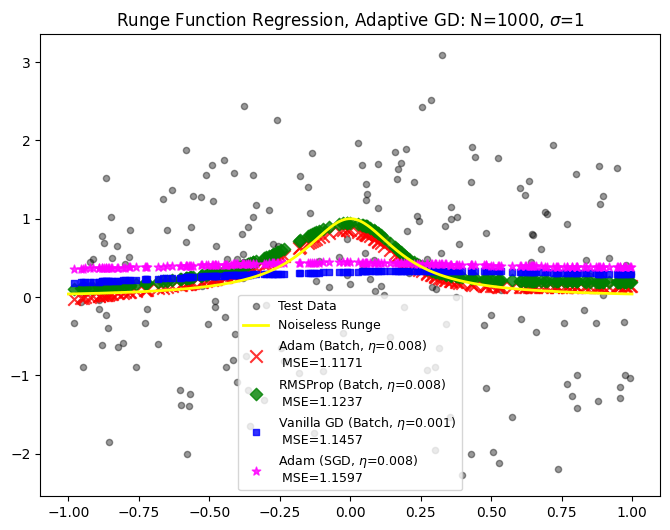

In [284]:
# Define optimizer–batch configurations
configs = [
    ("Adam (Batch,", "adam", "batch"),
    ("RMSProp (Batch,", "rmsprop", "batch"),
    ("Vanilla GD (Batch,", "vanilla", "batch"),
    ("Adam (SGD,", "adam", "stochastic")
]

# Corresponding learning rates (one per config)
learning_rates = [0.008, 0.008, 0.001, 0.008]
epochs = [500, 500, 1000, 1000]
# Store results 
results = {}

for (label, opt, batch_type), lr, epoch in zip(configs, learning_rates, epochs):
    print(f"\n-> Training model: {label} (LR={lr})")

    model = YANNI(
        ProblemType='regression',
        network_architecture=[1, 50, 100, 1],
        activation_funcs=[sigmoid, sigmoid, linear],
        learning_rate=lr,
        optimizer=opt,
        regularization=None,
        lambdaVal=0.0,
        batch_type=batch_type,
        max_iter=2000,
        max_epoch=epoch,
        tol=1e-5
    )

    model.train(X_train_scaled, y_train_scaled)
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_pred_scaled + y_offset
    mse_test = np.mean((y_test - y_pred)**2)

    results[rf"{label} $\eta$={lr})"] = (x_test, y_pred, mse_test)

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data', color='black', s=20, alpha=0.4)

# True noiseless Runge
plot_xaxis2, plot_yaxis2 = runge_function(500, noise=False)
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow', linewidth=2)

# Add predictions
colors = ['red', 'green', 'blue', 'magenta']
markers = ['x', 'D', 's', '*']
sizes = [80, 40, 20, 40]

for (label, (x_test, y_pred, mse_val)), color, marker, size in zip(results.items(), colors, markers, sizes):
    plt.scatter(x_test, y_pred, label=f'{label} \n MSE={mse_val:.4f}',
                color=color, marker=marker, s=size, alpha=0.8)

plt.title(fr"Runge Function Regression, Adaptive GD: N={N}, $\sigma$={stdev}")
plt.legend(fontsize=9)
plt.show()

### Testing 1D Runge with different Sigmas (best performing architecture/optimizer)

In [123]:
# Generate Runge data
N = 1000
stdev=0.5
x, y = runge_function(N, noise=True, stdev=stdev)
X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, max_eig = pre_processing(x, y)

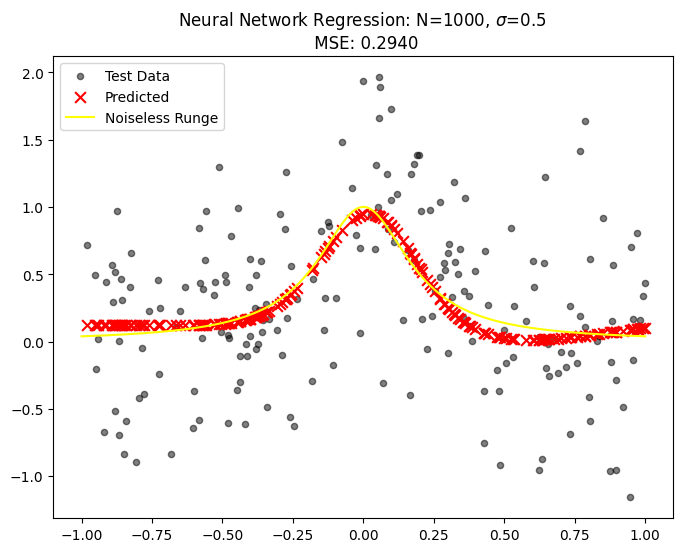

In [124]:
# Build Neural Network
model = YANNI(
    ProblemType='regression',
    network_architecture=[1, 50, 100, 1],
    activation_funcs=[sigmoid, sigmoid, linear],  # linear output
    learning_rate=0.01,
    optimizer='adam',
    regularization=None,
    lambdaVal=0.0,
    batch_type='batch',  # full batch for regression
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)

# Train
model.train(X_train_scaled, y_train_scaled)

# Evaluate
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_pred_scaled + y_offset  # add offset back
# Compute MSE on test set
mse_test = np.mean((y_test - y_pred)**2)

plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data', s=20, color='black',alpha=0.5)
plt.scatter(x_test, y_pred, label='Predicted', color='red', marker='x', s=60, alpha=1)

plot_xaxis2, plot_yaxis2 = runge_function(N, False)
x_gauss = np.linspace(-1, 1, 500)
sigma = 0.15
gaussian = np.exp(-x_gauss**2 / (2 * sigma**2))
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow')
# plt.plot(x_gauss, gaussian, label=rf'Gaussian $\sigma$={sigma}', color='cyan')

plt.title(f"Neural Network Regression: N={N}, $\sigma$={stdev} \n MSE: {mse_test:.4f}")
plt.legend()
plt.show()

### Test different Activation Function Layout

In [409]:
# Generate Runge data
N = 1000
stdev=0.8
x, y = runge_function(N, noise=True, stdev=stdev)
X_train_scaled, X_test_scaled, x_train, x_test, y_train_scaled, y_offset, y_test, max_eig = pre_processing(x, y)


→ Training model: Linear–Sigmoid

→ Training model: Sigmoid–Linear

→ Training model: Sigmoid-ReLU_leaky


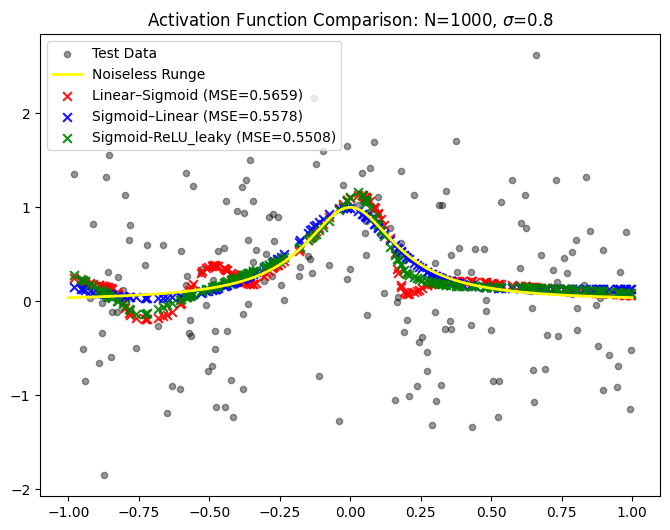

In [412]:
# Define architectures to compare
architectures = {
    "Linear–Sigmoid": [linear, sigmoid, linear],
    "Sigmoid–Linear": [sigmoid, linear, linear],
    "Sigmoid-ReLU_leaky": [sigmoid, ReLU_leaky, linear]
}

results = {}

for label, activations in architectures.items():
    print(f"\n→ Training model: {label}")
    
    # Build Neural Network
    model = YANNI(
        ProblemType='regression',
        network_architecture=[1, 50, 100, 1],
        activation_funcs=activations,
        learning_rate=0.008,
        optimizer='adam',
        regularization=None,
        lambdaVal=0.0,
        batch_type='batch',  # full batch for regression
        max_iter=2000,
        max_epoch=500,
        tol=1e-5
    )

    # Train
    model.train(X_train_scaled, y_train_scaled)

    # Predict
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = y_pred_scaled + y_offset

    # Compute MSE
    mse_test = np.mean((y_test - y_pred)**2)
    results[label] = (x_test, y_pred, mse_test)

# Plot comparison
plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, label='Test Data', s=20, color='black', alpha=0.4)

# True noiseless Runge
plot_xaxis2, plot_yaxis2 = runge_function(N, False)
plt.plot(plot_xaxis2, plot_yaxis2, label='Noiseless Runge', color='yellow', linewidth=2)

# Plot model predictions
colors = ['red', 'blue', 'green']
markers = ['x', 'x', 'x']

for (label, (x_test, y_pred, mse)), color, marker in zip(results.items(), colors, markers):
    plt.scatter(x_test, y_pred, label=f'{label} (MSE={mse:.4f})', color=color, marker=marker, s=40, alpha=0.9)

plt.title(fr"Activation Function Comparison: N={N}, $\sigma$={stdev}")
plt.legend()
plt.legend(fontsize=10)
plt.show()

### Regression: **2D $R(x,y, \sigma)$** Stress Testing best performing optimizer with regularization (L2/L1) for $\sigma_R \in$ (0.1, 0.3) 

### test (still 1D): plot different noise levels


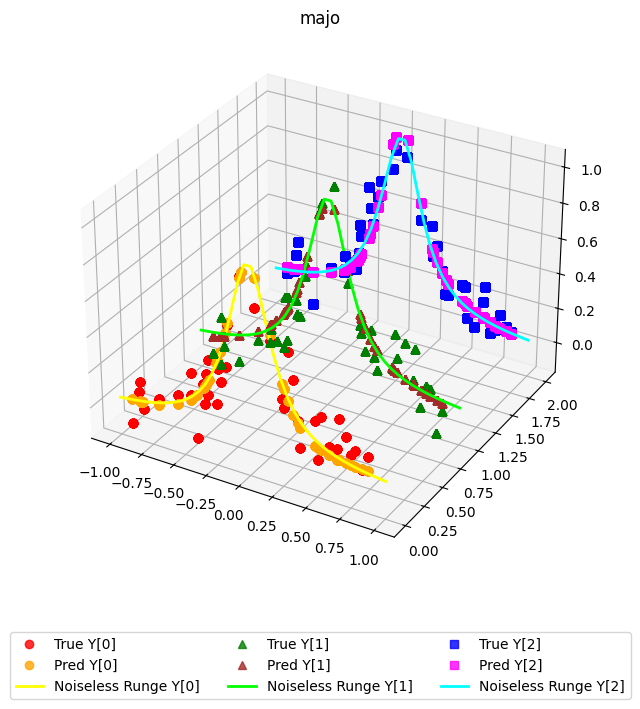

In [ ]:
N = 200
stdev=0.1
x, _ = runge_function(N, noise=False, stdev=stdev)  
_, y1 = runge_function(N, noise=True, stdev=stdev)  
_, y2 = runge_function(N, noise=True, stdev=stdev)  
_, y3 = runge_function(N, noise=True, stdev=stdev)
Y = np.hstack([y1, y2, y3])          # shape (N,3)

X_train_scaled, X_test_scaled, x_train, x_test, Y_train_scaled, Y_offset, Y_test, max_eig = pre_processing(x, Y)   #np.asarray(x).reshape(-1, 1)

model = YANNI(
    ProblemType='regression',
    network_architecture=[1, 50, 100, 3],
    activation_funcs=[sigmoid, sigmoid, linear],
    learning_rate=0.01,
    optimizer='adam',
    batch_type='batch',
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)
model.train(X_train_scaled, Y_train_scaled)
Y_pred_scaled = model.predict(X_test_scaled)
Y_pred = Y_pred_scaled + Y_offset 

markers = ['o', '^', 's']
colors_true = ['red', 'green', 'blue']
colors_pred = ['orange', 'brown', 'magenta']
colors_runge = ['yellow', 'lime', 'cyan']  # colors for true Runge functions

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot each component
for i in range(3):
    # True and predicted points
    ax.plot(x_test.ravel(), i*np.ones_like(x_test), Y_test[:, i],
            linestyle='None', marker=markers[i], alpha=0.8,
            label=f'True Y[{i}]', color=colors_true[i])
    ax.plot(x_test.ravel(), i*np.ones_like(x_test), Y_pred[:, i],
            linestyle='None', marker=markers[i], alpha=0.8,
            label=f'Pred Y[{i}]', color=colors_pred[i])
    
    # Overlay noiseless Runge curve for this component
    plot_xaxis2, plot_yaxis2 = runge_function(len(x_test), False)
    # Slight offset for 3D visualization (y = i)
    ax.plot(plot_xaxis2, i*np.ones_like(plot_xaxis2), plot_yaxis2,
            color=colors_runge[i], linewidth=2, label=f'Noiseless Runge Y[{i}]')
ax.set_title('majo')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)
plt.show()

### Define the 2D Runge function

In [11]:
def runge_function_2d(N, noise=True, stdev=0.1):
    '''
    Define 2D Runge function for proper 3D surface plotting
    '''
    grid_size = int(np.sqrt(N))
    x1 = np.linspace(-1, 1, grid_size)
    x2 = np.linspace(-1, 1, grid_size)
    X1, X2 = np.meshgrid(x1, x2)
    # 2D Runge function: 1/(1 + 25*(x1^2 + x2^2))
    # y = 1/(1 + 25*(X1**2 + X2**2))
    y = 1/( 1 + (10*X1-5)**2 + (10*X2**2-5)**2 )
    if noise:
        y += np.random.normal(0, stdev, size=y.shape)
    return np.column_stack([X1.ravel(), X2.ravel()]), y.ravel()

# Generate 2D data
N = 256  # Perfect square for meshgrid
x_2d, y_true = runge_function_2d(N, noise=False, stdev=0)
test_stdevs = [0.1, 0.3]

# Generate multiple noisy outputs, with Uncorrelated noise
_, y1 = runge_function_2d(N, noise=True, stdev=test_stdevs[0])
_, y2 = runge_function_2d(N, noise=True, stdev=test_stdevs[1])  
# _, y3 = runge_function_2d(N, noise=True, stdev=test_stdevs[2])
Y_2d = np.column_stack([y1, y2])   #Y_2d = np.column_stack([y1, y2, y3])
# x_2d(N,2), Y_2d(N,3)

# Save the grid stucture before preprocessing with train test split
grid_size = int(np.sqrt(N))
X1_original = x_2d[:, 0].reshape(grid_size, grid_size)
X2_original = x_2d[:, 1].reshape(grid_size, grid_size)

# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(x_2d, Y_2d, test_size=0.2, random_state=42)

# New preprocessing: standard scaling, offset separation but for 2d meshgrid
x_scaler = StandardScaler()
X_train_scaled = x_scaler.fit_transform(X_train)  
X_test_scaled = x_scaler.transform(X_test)        

y_scaler = StandardScaler()
Y_train_scaled = y_scaler.fit_transform(Y_train)  
Y_test_scaled = y_scaler.transform(Y_test)        

# Store scaling parameters for later
Y_offset = y_scaler.mean_
Y_scale = y_scaler.scale_

### 2 hidden layers, sigmoids adam, without regularzation

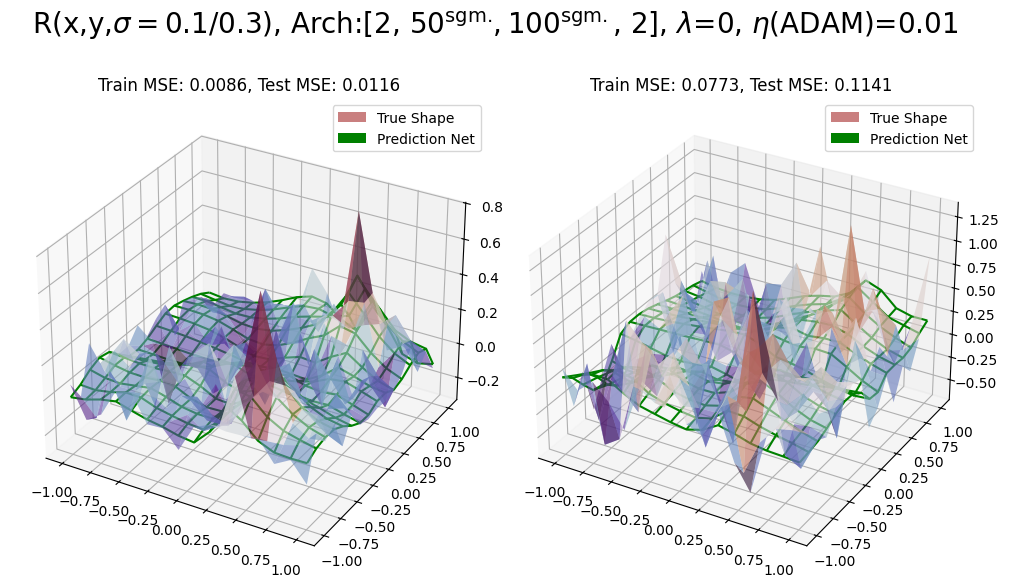

In [710]:
activation_init = [sigmoid, sigmoid, linear]
arch_init = [2, 50, 100, 2]   #3 if 3 sigmas
model = YANNI(
    ProblemType='regression',
    network_architecture=arch_init,
    activation_funcs=activation_init,
    learning_rate=0.01,
    optimizer='adam',
    batch_type='batch',
    max_iter=2000,
    max_epoch=500,
    tol=1e-5
)
model.train(X_train_scaled, Y_train_scaled)

# Predict on all scaled data
Y_train_pred_scaled = model.predict(X_train_scaled)
Y_test_pred_scaled = model.predict(X_test_scaled)
Y_train_pred = Y_train_pred_scaled * Y_scale + Y_offset
Y_test_pred = Y_test_pred_scaled * Y_scale + Y_offset

# Evaluate OVERFIT using MSE TRAIN/TEST
train_mse = []
test_mse = []
for i in range(2):   #3
    train_mse.append(mean_squared_error(Y_train[:, i], Y_train_pred[:, i]))
    test_mse.append(mean_squared_error(Y_test[:, i], Y_test_pred[:, i]))

# Vaisalize THE FULL TRAIN+TEST data (because of grid)

X_full_scaled = x_scaler.transform(x_2d)  
Y_full_pred_scaled = model.predict(X_full_scaled)
Y_full_pred = Y_full_pred_scaled * Y_scale + Y_offset

fig = plt.figure(figsize=(10, 6))
for i in range(2):   #3
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    
    # Reshape to grid
    Y_true_surface = Y_2d[:, i].reshape(grid_size, grid_size)
    Y_pred_surface = Y_full_pred[:, i].reshape(grid_size, grid_size)
    
    # Plot true surface
    surf_true = ax.plot_surface(X1_original, X2_original, Y_true_surface, alpha=0.6, cmap='twilight_shifted', label='True')
    
    # Plot predicted surface as Fish Net
    surf_pred = ax.plot_wireframe(X1_original, X2_original, Y_pred_surface, color='green', alpha=1, label='Predicted')
    
    ax.set_title(f'Train MSE: {train_mse[i]:.4f}, Test MSE: {test_mse[i]:.4f}')
    
    # Create proxy artists for legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='brown', alpha=0.6, label='True Shape'),
        Patch(facecolor='green', alpha=1, label='Prediction Net')
    ]
    ax.legend(handles=legend_elements)
fig.suptitle(r'R(x,y,$\sigma=0.1/0.3$), Arch:[2, $50^{\text{sgm.}}, 100^{\mathrm{sgm.}}$, 2], $\lambda$=0, $\eta$(ADAM)=0.01' f'\n', fontsize=20)
plt.tight_layout()
plt.show()

### 3 hidden layers, no regularzaiton

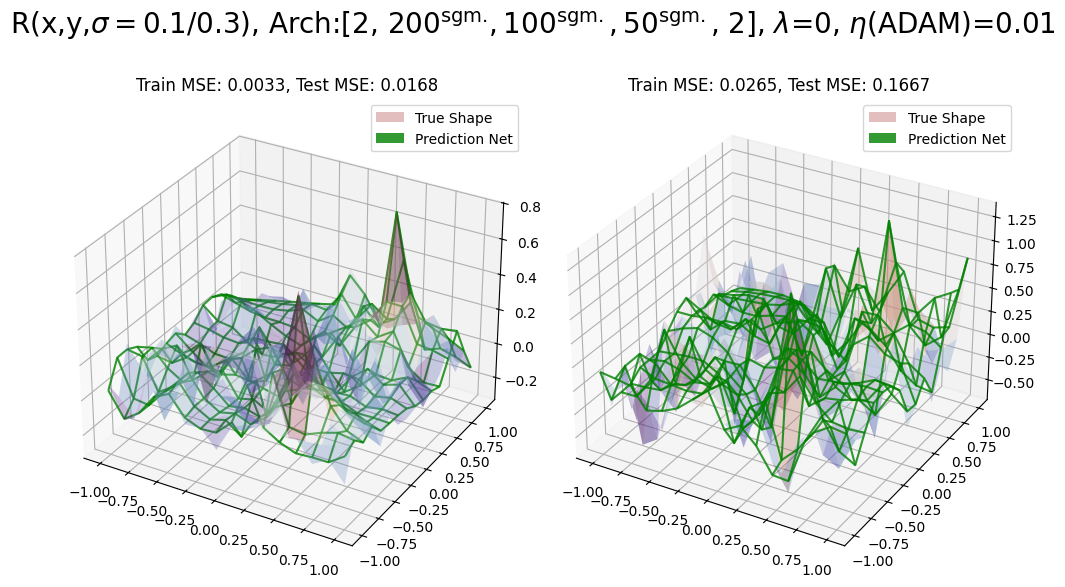

In [743]:
model = YANNI(
    ProblemType='regression',
    network_architecture=[2, 200, 100, 50, 2],   # deeper network [50, 200, 100, 50]
    activation_funcs=[sigmoid, sigmoid, sigmoid, linear],
    learning_rate=0.01,   #0.01
    optimizer='adam',
    batch_type='batch',
    max_iter=3000,   #2000
    max_epoch=500,   #500
    tol=1e-5,
    regularization='L2',
    lambdaVal=0   #1e-5
)

model.train(X_train_scaled, Y_train_scaled)

# Predict on all scaled data
Y_train_pred_scaled = model.predict(X_train_scaled)
Y_test_pred_scaled = model.predict(X_test_scaled)
Y_train_pred = Y_train_pred_scaled * Y_scale + Y_offset
Y_test_pred = Y_test_pred_scaled * Y_scale + Y_offset

# Evaluate OVERFIT using MSE TRAIN/TEST
train_mse = []
test_mse = []
for i in range(2):   #3
    train_mse.append(mean_squared_error(Y_train[:, i], Y_train_pred[:, i]))
    test_mse.append(mean_squared_error(Y_test[:, i], Y_test_pred[:, i]))

# Vaisalize THE FULL TRAIN+TEST data (because of grid)

X_full_scaled = x_scaler.transform(x_2d)  
Y_full_pred_scaled = model.predict(X_full_scaled)
Y_full_pred = Y_full_pred_scaled * Y_scale + Y_offset

fig = plt.figure(figsize=(10, 6))
for i in range(2):   #3
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    
    # Reshape to grid
    Y_true_surface = Y_2d[:, i].reshape(grid_size, grid_size)
    Y_pred_surface = Y_full_pred[:, i].reshape(grid_size, grid_size)
    
    # Plot true surface
    surf_true = ax.plot_surface(X1_original, X2_original, Y_true_surface, alpha=0.3, cmap='twilight_shifted', label='True')
    
    # Plot predicted surface as Fish Net
    surf_pred = ax.plot_wireframe(X1_original, X2_original, Y_pred_surface, color='green', alpha=0.8, label='Predicted')
    
    ax.set_title(f'Train MSE: {train_mse[i]:.4f}, Test MSE: {test_mse[i]:.4f}')
    
    # Create proxy artists for legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='brown', alpha=0.3, label='True Shape'),
        Patch(facecolor='green', alpha=0.8, label='Prediction Net')
    ]
    ax.legend(handles=legend_elements)
fig.suptitle(r'R(x,y,$\sigma=0.1/0.3$), Arch:[2, $200^{\text{sgm.}}, 100^{\mathrm{sgm.}}, 50^{\mathrm{sgm.}}$, 2], $\lambda$=0, $\eta$(ADAM)=0.01' f'\n', fontsize=20)
plt.tight_layout()
plt.show()

### Overfitting vs Regularization (L1/L2)

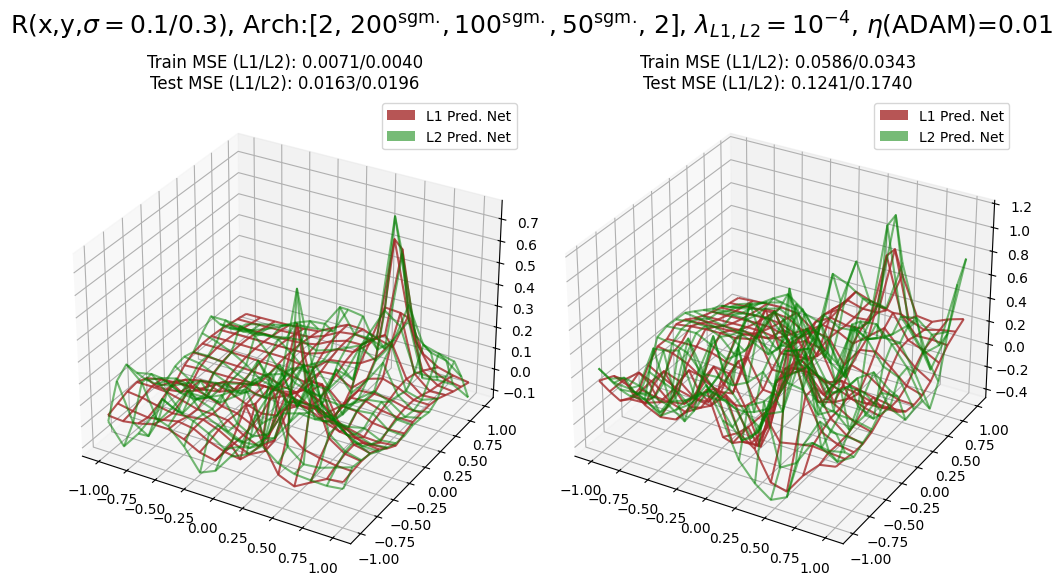

In [852]:
configs = [
    ("L1", "L1", 1e-4),    #8e-5
    ("L2", "L2", 1e-4)
]

# store ressults
results = {}

for label, reg_type, lambda_val in configs:

    model = YANNI(
        ProblemType='regression',
        network_architecture=[2, 200, 100, 50, 2],   # deeper network [50, 200, 100, 50]
        activation_funcs=[sigmoid, sigmoid, sigmoid, linear],
        learning_rate=0.01,   # 0.01
        optimizer='adam',
        batch_type='batch',   # full batch for regression
        max_iter=3000,        # 2000
        max_epoch=500,        # 500
        tol=1e-5,             # THIS IS TOLERANCE, NOT REGULARIZATION
        regularization=reg_type,
        lambdaVal=lambda_val
    )

    model.train(X_train_scaled, Y_train_scaled)

    # Predict on scaled data
    Y_train_pred_scaled = model.predict(X_train_scaled)
    Y_test_pred_scaled = model.predict(X_test_scaled)
    Y_train_pred = Y_train_pred_scaled * Y_scale + Y_offset
    Y_test_pred = Y_test_pred_scaled * Y_scale + Y_offset

    # Compute MSEs
    train_mse = []
    test_mse = []
    for i in range(2):
        train_mse.append(mean_squared_error(Y_train[:, i], Y_train_pred[:, i]))
        test_mse.append(mean_squared_error(Y_test[:, i], Y_test_pred[:, i]))

    # Predict full grid
    X_full_scaled = x_scaler.transform(x_2d)
    Y_full_pred_scaled = model.predict(X_full_scaled)
    Y_full_pred = Y_full_pred_scaled * Y_scale + Y_offset

    results[label] = {
        "Y_pred": Y_full_pred,
        "train_mse": train_mse,
        "test_mse": test_mse
    }

# Plot both results in the same style as your original
fig = plt.figure(figsize=(10, 6))
colors = {"L1": "brown", "L2": "green"}    

for i in range(2):
    ax = fig.add_subplot(1, 2, i + 1, projection='3d')

    # Reshape true surface
    Y_true_surface = Y_2d[:, i].reshape(grid_size, grid_size)
    # surf_true = ax.plot_surface(X1_original, X2_original, Y_true_surface,alpha=0.3, cmap='twilight_shifted', label='True')

    # Plot both predicted surfaces (wireframes)
    for j, label in enumerate(results):
        Y_pred_surface = results[label]["Y_pred"][:, i].reshape(grid_size, grid_size)
        # Add small vertical offset to one of them to avoid overlap
        z_offset = 0 * j  
        surf_pred = ax.plot_wireframe(X1_original, X2_original, Y_pred_surface+z_offset,color=colors[label], alpha=0.8/(0.5*j+1), label=f'{label} Pred')

    # Title with MSEs from both models
    title_str = (
        f'Train MSE (L1/L2): {results["L1"]["train_mse"][i]:.4f}/{results["L2"]["train_mse"][i]:.4f}\n'
        f'Test MSE (L1/L2): {results["L1"]["test_mse"][i]:.4f}/{results["L2"]["test_mse"][i]:.4f}'
    )
    ax.set_title(title_str)

    # Legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='brown', alpha=0.8, label='L1 Pred. Net'),
        Patch(facecolor='green', alpha=0.8/(1.5), label='L2 Pred. Net')
    ]
    ax.legend(handles=legend_elements)

fig.suptitle(r'R(x,y,$\sigma=0.1/0.3$), Arch:[2, $200^{\text{sgm.}}, 100^{\mathrm{sgm.}}, 50^{\text{sgm.}}$, 2], $\lambda_{L1, L2}=10^{-4}$, $\eta$(ADAM)=0.01' f'\n',fontsize=18)
plt.tight_layout()
plt.show()

### ========================================================================================
### Mason-Dixon Line
### ========================================================================================